In [1]:
!pip install numpy==1.23.3

In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import calmap
import datetime
import tensorflow as tf
import os
import random
import re
import plotly.offline as pyoff
import plotly.graph_objs as go
import swifter

from scipy import signal
from datetime import date
from plotly.subplots import make_subplots
from itertools import cycle, product
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from scipy.stats import boxcox
from dateutil.parser import parse
from pmdarima.arima import auto_arima
from pmdarima.utils import diff_inv
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.initializers import *
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p, inv_boxcox1p
import matplotlib.patches as mpatches
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import GridSearchCV
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from IPython.display import HTML, display
from swifter import set_defaults
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

C:\Users\herik\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\herik\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\herik\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Herikc Brecher" --iversions

Author: Herikc Brecher

plotly      : 5.6.0
keras       : 2.10.0
calmap      : 0.0.9
tensorflow  : 2.10.0
seaborn     : 0.11.2
scipy       : 1.5.4
numpy       : 1.20.0
matplotlib  : 3.5.1
re          : 2.2.1
pandas      : 1.4.2
swifter     : 1.3.4
chart_studio: 1.1.0



In [4]:
# Variaveis globais
SEED = 84796315
FEATURES = 7
EPOCHS = 1000
BATCH_SIZE = 1000
EXECUTE_GRID_SEARCH = False

In [5]:
# Configurando seeds
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [6]:
# Exibindo toda tela
display(HTML('<style>.container { width:100% !important; }</style>'))
pd.options.plotting.backend = 'matplotlib'

In [7]:
# Configurando swifter 
set_defaults(
    npartitions = None,
    dask_threshold = 1,
    scheduler = "processes",
    progress_bar = True,
    progress_bar_desc = None,
    allow_dask_on_strings = True,
    force_parallel = True,
)

# 1. Preparando Conjunto de Pedidos

In [8]:
# Import dataset
dtOrders = pd.read_csv('../data/olist_orders_dataset.csv', encoding = 'utf8')

In [9]:
# Colunas do tipo data
dateColumns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',\
               'order_delivered_customer_date', 'order_estimated_delivery_date']

# Dataset de analise temporal
dtOrdersAdjusted = dtOrders.copy()

In [10]:
# Convertendo columas de data para date
for col in dateColumns:
    dtOrdersAdjusted[col] = pd.to_datetime(dtOrdersAdjusted[col], format = '%Y-%m-%d %H:%M:%S')

In [11]:
# Dropando valores NA
dtOrdersAdjusted = dtOrdersAdjusted.dropna()

In [12]:
dtOrdersAdjusted.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

# 2. Iniciando Analise Seasonal

In [13]:
dtHistory = pd.to_datetime(dtOrdersAdjusted['order_purchase_timestamp']).dt.date

start = dtHistory.min()
end = dtHistory.max()

idx = pd.date_range(start, end, normalize = True)

seriesOriginal = dtHistory.value_counts(sort = False).sort_index().reindex(idx, fill_value = 0)

dtHistory = pd.DataFrame(seriesOriginal).reset_index()

Principais outliers identificados:

- 1 de setembro de 2016 a 31 de dezembro de 2016: Dados quase inexistentes
- 24 de novembro de 2017: Pico de venda devido ao evento da blackfriday
- 17 de agosto de 2017 a 17 de outubro de 2017: Queda repentina nos dados

In [14]:
dtHistory.rename(columns = {'index': 'Data', 'order_purchase_timestamp': 'Vendas'}, inplace = True)

In [15]:
dtHistory

Data  Vendas
0   2016-09-15       1
1   2016-09-16       0
2   2016-09-17       0
3   2016-09-18       0
4   2016-09-19       0
..         ...     ...
709 2018-08-25      69
710 2018-08-26      73
711 2018-08-27      66
712 2018-08-28      39
713 2018-08-29      11

[714 rows x 2 columns]

In [16]:
# Plot

# Definição dos dados no plot (Iniciando em Fevereiro de 2017 para não destorcer os dados)
plot_data = [go.Scatter(x = dtHistory['Data'],
                        y = dtHistory['Vendas'])]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Periodo'},
                        yaxis = {'title': 'Vendas'},
                        title = 'Vendas por dia')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
fig.update_layout(yaxis_range = [0, 800])

pyoff.iplot(fig) 

In [17]:
# Remove outliers
seriesOriginal = seriesOriginal[datetime.date(2017, 1, 1): datetime.date(2018, 8, 17)]
pred_range = pd.date_range(datetime.date(2018, 8, 17), datetime.date(2018, 10, 17))
dtHistory = pd.DataFrame(seriesOriginal).reset_index()

In [18]:
dtHistory.rename(columns = {'index': 'Data', 'order_purchase_timestamp': 'Vendas'}, inplace = True)

In [19]:
# Plot

# Definição dos dados no plot (Iniciando em Fevereiro de 2017 para não destorcer os dados)
plot_data = [go.Scatter(x = dtHistory['Data'],
                        y = dtHistory['Vendas'])]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Periodo'},
                        yaxis = {'title': 'Vendas'},
                        title = 'Vendas por Dia')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
fig.update_layout(yaxis_range = [0, 800])

pyoff.iplot(fig) 

In [20]:
# Plot

# Definição dos dados no plot (Iniciando em Fevereiro de 2017 para não destorcer os dados)
plot_data = [go.Scatter(x = dtHistory['Data'],
                        y = dtHistory['Vendas'],
                        showlegend = False),
            go.Scatter(x = dtHistory['Data'],
                       y = -dtHistory['Vendas'],
                       fill='tonexty',
                       showlegend = False)]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Periodo'},
                        yaxis = {'title': 'Vendas'},
                        title = 'Vendas por Dia Expandida')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

fig.update_traces(line_color = 'green')
fig.update_layout(yaxis_range = [-800 , 800])

pyoff.iplot(fig) 

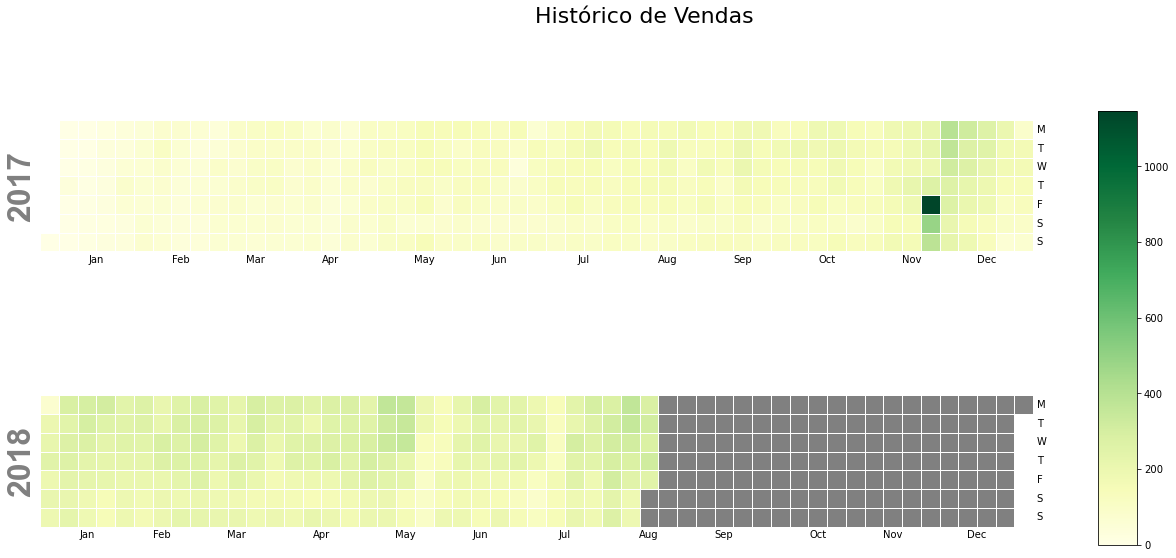

In [21]:
#Plot histórico de vendas por dia, mês e ano
fig, caxs = calmap.calendarplot(seriesOriginal, daylabels = 'MTWTFSS', fillcolor = 'grey',cmap = 'YlGn', fig_kws = dict(figsize = (18, 9)))
fig.suptitle('Histórico de Vendas', fontsize = 22)

fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.67])
fig.colorbar(caxs[0].get_children()[1], cax = cbar_ax)

plt.show()

In [22]:
# Criar grafico na estrutura STL 4 layers
def add_stl_plot(fig, res, legend):
    axs = fig.get_axes()
    
    # Nome de cada um dos subplots
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'resid':
            ax.plot(series, marker = 'o', linestyle = 'none')
        else:
            ax.plot(series)
            ax.legend(legend, frameon = False)

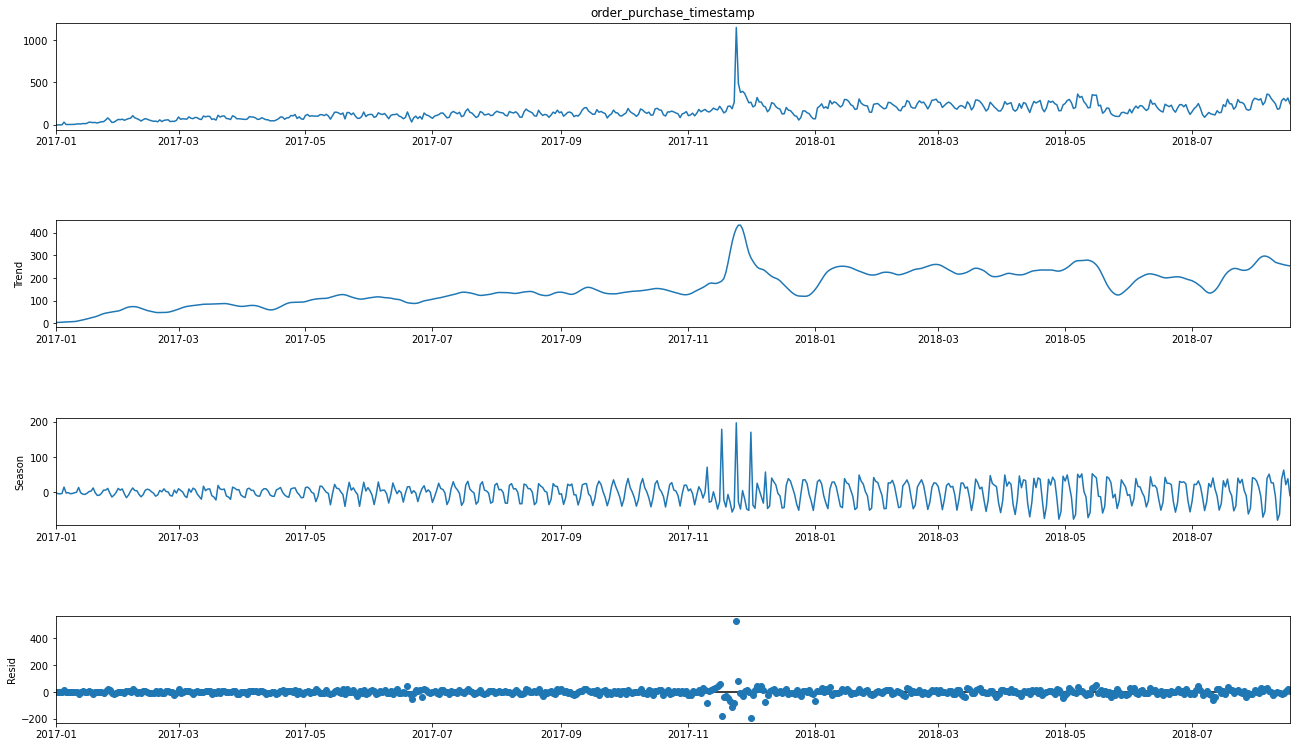

In [23]:
# Gerar STL
stl = STL(seriesOriginal)
stl_res = stl.fit()
fig = stl_res.plot()
fig.set_size_inches((20, 12))
plt.show()

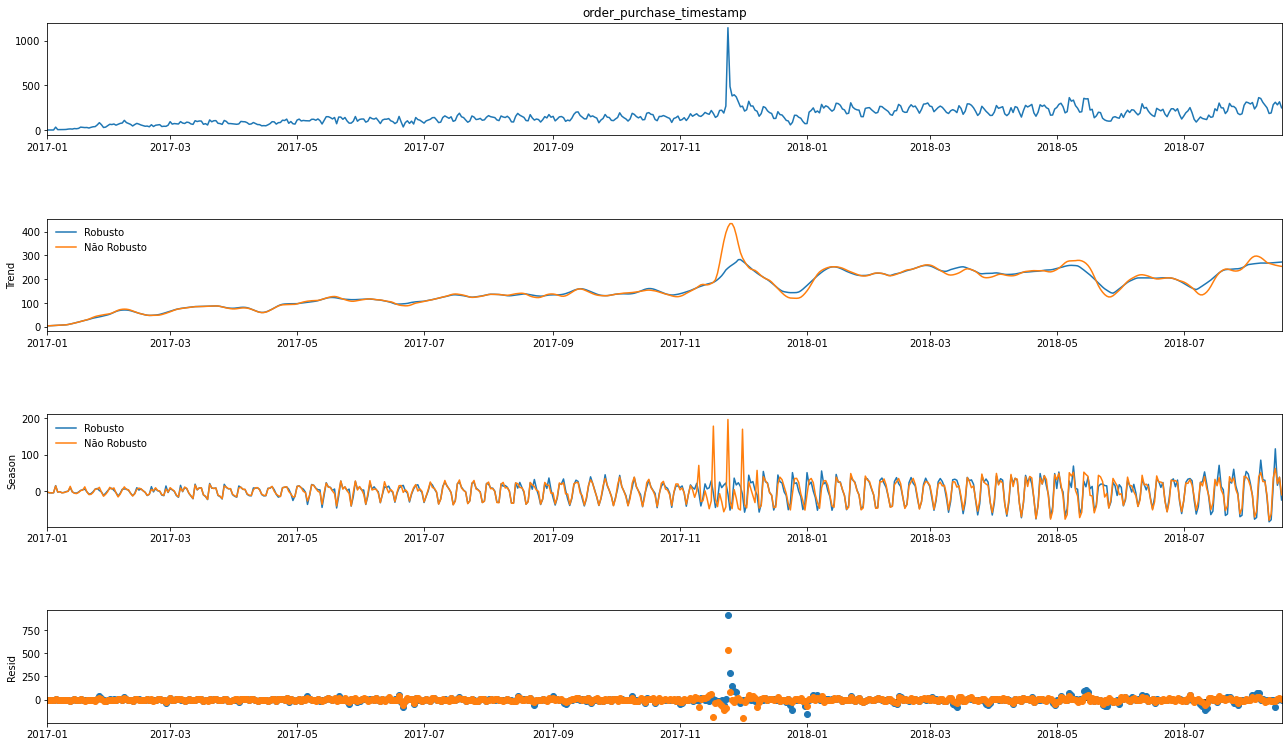

In [24]:
# Gerar STL não robusto e concatenar ao robusto
stl = STL(seriesOriginal, robust = True)
res_robust = stl.fit()
fig = res_robust.plot()
fig.set_size_inches((20, 12))
res_non_robust = STL(seriesOriginal, robust = False).fit()
add_stl_plot(fig, res_non_robust, ['Robusto', 'Não Robusto'])

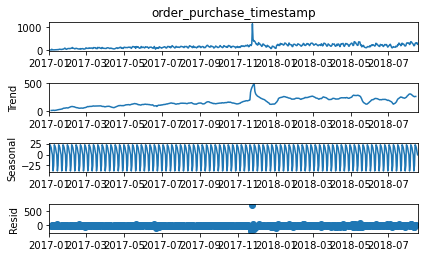

In [25]:
# Additive Decomposition
additive_decomposition = seasonal_decompose(seriesOriginal, model = 'additive', period = FEATURES)

# Plot
additive_decomposition.plot()
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.rcParams["figure.figsize"] = (20, 10)

plt.show()

In [26]:
# Removendo tendência
detrended = signal.detrend(seriesOriginal)

# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = seriesOriginal.index,
                        y = detrended)]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Período'},
                        yaxis = {'title': 'Vendas'}, 
                        title = 'Vendas Diárias Removendo a Tendência')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)
fig.update_layout(yaxis_range = [-800 , 800])

pyoff.iplot(fig)

In [27]:
# Gerando STL para separar cada um dos componentes
stl = STL(seriesOriginal)
res = stl.fit()

# Separando seriesDeseasonal
seriesDeseasonal = res.observed - res.seasonal

# Separando boxcox
seriesBoxCox, lmbda = boxcox(seriesOriginal + 1)
seriesBoxCox = pd.Series(seriesBoxCox, index = seriesOriginal.index)

# Separando stationary
seriesResidual = seriesOriginal.diff(7).dropna()

## 2.1 Teste Estacionário ADF

Os testes abaixo concluiram:

O teste aceita a hipótese nula em que a série não é estácionária para os dados originais e deseasonal. Já para os dados residuais esses aceitaram a hipótese alternativa que os dados são estacionários. 

ADF teste:

- Hipótese Nula(HO): A série possui unit root ou não é estacionária.
- Hipótese Alternativa(HA):  A série não possui unit root ou é estacionária.

In [28]:
print("Os dados são estacionários?\n")
testResult = adfuller(seriesOriginal, autolag = 'AIC')
print("Valor Teste = {:.3f}".format(testResult[0]))
print("Valor de P: = {:.3f}".format(testResult[1]))
print("\nValores Críticos:")

for p, v in testResult[4].items():
    print("\t{}: {} - O dataset {} é estacionário com {}% de confiança".format(p, v, "não" if v < testResult[0] else "", 100 - int(p[:-1])))

Os dados são estacionários?

Valor Teste = -2.616
Valor de P: = 0.090

Valores Críticos:
	1%: -3.441694608475642 - O dataset não é estacionário com 99% de confiança
	5%: -2.866544718556839 - O dataset não é estacionário com 95% de confiança
	10%: -2.5694353738653684 - O dataset  é estacionário com 90% de confiança


In [29]:
print("Os dados deseasonal são estacionários?")
testResult = adfuller(seriesDeseasonal, autolag = 'AIC')
print("Valor Teste = {:.3f}".format(testResult[0]))
print("Valor de P: = {:.3f}".format(testResult[1]))
print("\nValores Críticos:")

for p, v in testResult[4].items():
    print("\t{}: {} - O dataset {} é estacionário com {}% de confiança".format(p, v, "não" if v < testResult[0] else "", 100 - int(p[:-1])))

Os dados deseasonal são estacionários?
Valor Teste = -2.536
Valor de P: = 0.107

Valores Críticos:
	1%: -3.441694608475642 - O dataset não é estacionário com 99% de confiança
	5%: -2.866544718556839 - O dataset não é estacionário com 95% de confiança
	10%: -2.5694353738653684 - O dataset não é estacionário com 90% de confiança


In [30]:
print("Os dados residuais são estacionários?")
testResult = adfuller(seriesResidual, autolag = 'AIC')
print("Valor Teste = {:.3f}".format(testResult[0]))
print("Valor de P: = {:.3f}".format(testResult[1]))
print("\nValores Críticos:")

for p, v in testResult[4].items():
    print("\t{}: {} - O dataset {} é estacionário com {}% de confiança".format(p, v, "não" if v < testResult[0] else "", 100 - int(p[:-1])))

Os dados residuais são estacionários?
Valor Teste = -6.802
Valor de P: = 0.000

Valores Críticos:
	1%: -3.441834071558759 - O dataset  é estacionário com 99% de confiança
	5%: -2.8666061267054626 - O dataset  é estacionário com 95% de confiança
	10%: -2.569468095872659 - O dataset  é estacionário com 90% de confiança


# 3. Modelagem

Toda a etapa de modelagem será considerada com 5 passos a frente de previsão.

In [31]:
# Controle de resultados de toda fase de modelagem
result = pd.DataFrame(columns = ['Algorithm', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Mean_True_Value', 'Mean_Predict_Value'])

In [32]:
split_range = TimeSeriesSplit(n_splits = 8, max_train_size = pred_range.shape[0], test_size = pred_range.shape[0])

In [33]:
# Adiciona o registro ao dataset
def record(result, algorithm, mse = -1, rmse = -1, mae = -1, mape = -1, mrv = -1, mpv = -1, show = True):
    new = pd.DataFrame(dict(Algorithm = algorithm, MSE = mse, RMSE = rmse, MAE = mae, MAPE = mape, Mean_True_Value = mrv,\
                            Mean_Predict_Value = mpv), index = [0])
    result = pd.concat([result, new], ignore_index = True)
    
    if show:
        display(result)
    
    return result

In [34]:
# Plot no formato de 4 layers, seguindo o STL para cada um dos modelos
def plot(index, pred, mse, title, fig = None, ax = None, ylabel = ''):
    global seriesOriginal
    
    empty_fig = fig is None
    
    if empty_fig:
        fig, ax = plt.subplots(figsize = (13, 6))
    else: 
        ax.set_ylabel(ylabel)
                
    ax.set_title(title)    
    patch_ = mpatches.Patch(color = 'white', label = f'MSE: {np.mean(mse):.1e}')
    L1 = ax.legend(handles = [patch_], loc = 'upper left', fancybox = True, framealpha = 0.7,  handlelength = 0)
    ax.add_artist(L1)
    
    sns.lineplot(x = seriesOriginal.index, y = seriesOriginal, label = 'Real', ax = ax)
    sns.lineplot(x = index, y = pred, label = 'Previsto', ax = ax)
    ax.axvline(x = index[0], color = 'red')
    ax.legend(loc = 'upper right')
    ax.set_ylim([0, 800])
    
    if empty_fig:
        plt.show()
    else:
        return fig

In [35]:
# Calculo para previsão e teste quando utilizado a série Original
def calcPredTestOriginal(train, pred, test):
    return pred, test, 0

In [36]:
# Calculo para previsão e teste quando utilizado a série seriesDeseasonal
def calcPredTestseriesDeseasonal(train, pred, test):
    # Removendo a sazonalidade da série e convertendo para o shape correto
    last_seasonal = res.seasonal.reindex_like(train).tail(stl.period)
    pred = pred + np.fromiter(cycle(last_seasonal), count = pred.shape[0], dtype = float)
    test = test + res.seasonal.reindex_like(test)
    
    return pred, test, 1

In [37]:
# Calculo para previsão e teste quando utilizado a série BoxCox
def calcPredTestBoxCox(train, pred, test):
    # Reverdendo a normalização do boxcox
    pred = inv_boxcox1p(pred, lmbda)
    test = inv_boxcox1p(test, lmbda)
    
    return pred, test, 2

In [38]:
# Calculo para previsão e teste quando utilizado a série Stationary
def calcPredTestStationary(train, pred, test):
    # Calculando a diferença da sazonalidade
    xi = seriesOriginal.reindex_like(train).tail(FEATURES)
    
    totalLen = len(pred) + len(xi) 
    ix = pd.date_range(xi.index[0], periods = totalLen)  
    inv = diff_inv(pred, FEATURES, xi = xi) + np.fromiter(cycle(xi), count = totalLen, dtype = float)  
    inv = pd.Series(inv, index = ix, name = 'Vendas')
    pred = inv.iloc[FEATURES:]
    
    totalLen = len(test) + len(xi) 
    ix = pd.date_range(xi.index[0], periods = totalLen)  
    inv = diff_inv(test, FEATURES, xi = xi) + np.fromiter(cycle(xi), count = totalLen, dtype = float)  
    inv = pd.Series(inv, index = ix, name = 'Vendas')
    test = inv.iloc[FEATURES:]
    
    return pred, test, 3

In [39]:
def calculate_metrics_off(test, pred):
    mse = mean_squared_error(test, pred, squared = True)
    rmse = mean_squared_error(test, pred, squared = False)
    mae = mean_absolute_error(test, pred)
    mape = mean_absolute_percentage_error(test, pred) * 100
    mtv = np.mean(test)
    mpv = np.mean(pred)
    
    return mse, rmse, mae, mape, mtv, mpv

In [40]:
def calculate_metrics_on(test, pred, mse, rmse, mae, mape, mtv, mpv):
    mse_, rmse_, mae_, mape_, mtv_, mpv_ = calculate_metrics_off(test, pred)
    
    mse.append(mse_)
    rmse.append(rmse_)
    mae.append(mae_)
    mape.append(mape_)
    mtv.append(mtv_)
    mpv.append(mpv_)
    
    return mse, rmse, mae, mape, mtv, mpv

## 3.1 TSR (Time Series Regression)

In [41]:
# Report para Time Series Regressor, realiza o treino do modelo, adiciona aos resultados e faz o plot de acompanhamento
def reportTSR(data, modelName, calcFunction):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mape = []
    mtv = []
    mpv = []
    
    title = modelName + ' - Time Series Regression'
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
    
        gen = TimeseriesGenerator(train, train, FEATURES, batch_size = BATCH_SIZE)

        X_train = gen[0][0]
        y_train = gen[0][1]

        lr = LinearRegression()
        lr.fit(X_train, y_train)
        X_pred = y_train[-FEATURES:].reshape(1,-1)
        pred = np.empty(test.shape[0])

        for i in range(len(pred)):
            forecast = lr.predict(X_pred)
            X_pred = np.delete(X_pred, 0, 1)
            X_pred = np.concatenate((X_pred, forecast.reshape(-1, 1)), 1)    
            pred[i] = forecast
        
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse, rmse, mae, mape, mtv, mpv = calculate_metrics_on(test, pred, mse, rmse, mae, mape, mtv, mpv)
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mape), np.mean(mtv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [42]:
# Reset da figura
figs, axs = plt.subplots(nrows = 4, sharex = True, figsize = (13,6))
figs.tight_layout()
plt.close()

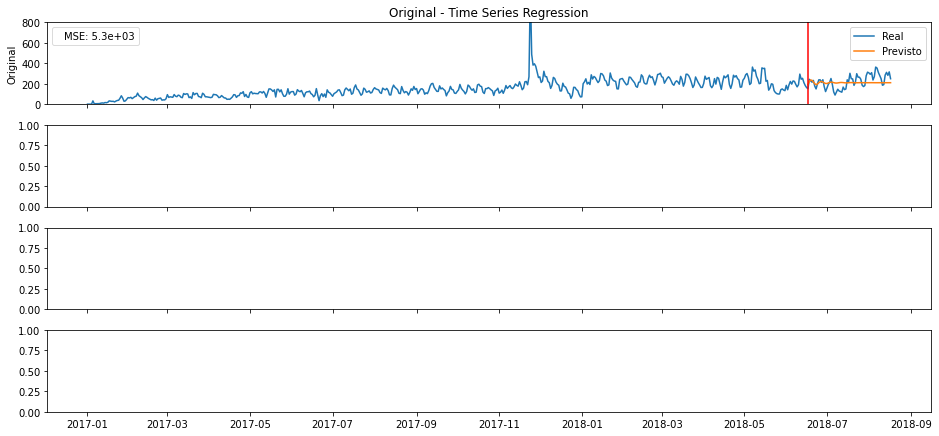

In [43]:
reportTSR(seriesOriginal.copy(), 'Original', calcPredTestOriginal)

## 3.2 Deseasonal - TSR (Time Series Regression)

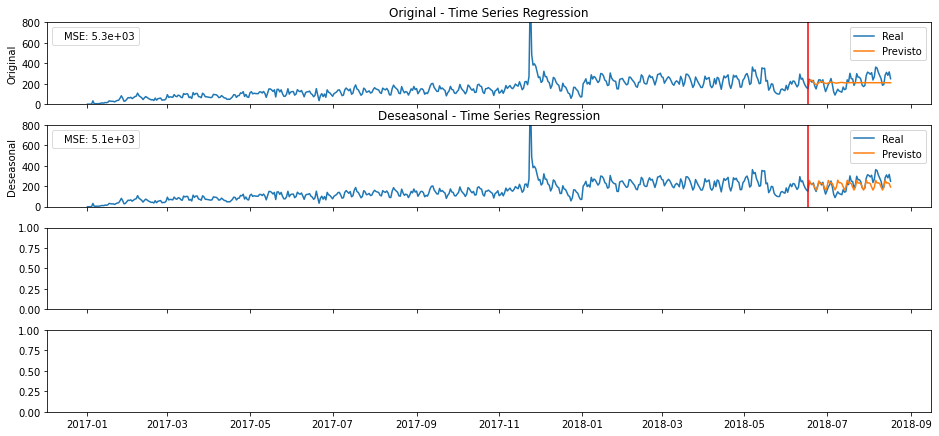

In [44]:
reportTSR(seriesDeseasonal.copy(), 'Deseasonal', calcPredTestseriesDeseasonal)

## 3.3 BoxCox - TSR (Time Series Regression)

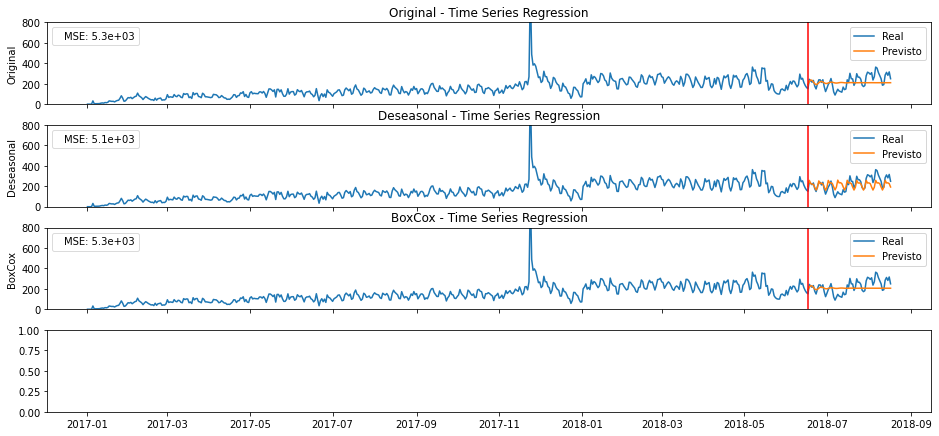

In [45]:
reportTSR(seriesBoxCox.copy(), 'BoxCox', calcPredTestBoxCox)

## 3.4 Residual - TSR (Time Series Regression)

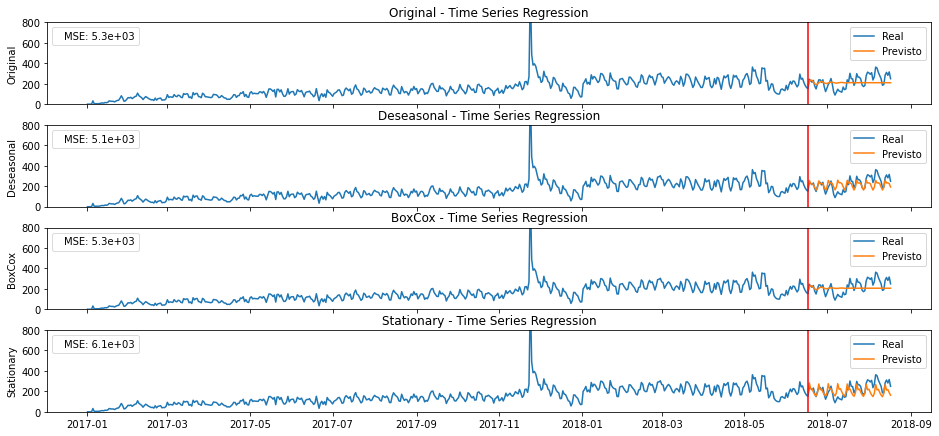

In [46]:
reportTSR(seriesResidual.copy(), 'Stationary', calcPredTestStationary)

In [47]:
result

Algorithm          MSE       RMSE        MAE  \
0    Original - Time Series Regression  5296.329792  60.784585  42.960631   
1  Deseasonal - Time Series Regression   5081.77776  58.208746  40.122247   
2      BoxCox - Time Series Regression  5328.602465  61.060147  43.254815   
3  Stationary - Time Series Regression  6057.828087  64.323443  46.538896   

        MAPE Mean_True_Value Mean_Predict_Value  
0  25.553663      179.560484         168.008596  
1  23.488563      179.560484         164.670085  
2  25.416806      179.560484         165.399796  
3  27.899678      179.560484         184.267746

## 3.5 Exponential Smoothing

In [48]:
# Função utilizada para o hypertuning de alpha, beta e gamma do Exponential Smoothing
def GSES(data, modelName, alpha, beta, gamma, damping_trend, calcFunction):    
    mse = []
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        try:
            with catch_warnings():
                filterwarnings('ignore')
                ES = (
                    ExponentialSmoothing(train, trend = 'add', seasonal = 'add', seasonal_periods = FEATURES, damped_trend = True)
                    .fit(smoothing_level = alpha, smoothing_trend = beta, smoothing_seasonal = gamma, method = 'ls', damping_trend = damping_trend)
                )

                pred = ES.forecast(test.shape[0])

                pred, test, _ = calcFunction(train, pred, test)

                mse.append(mean_squared_error(pred, test, squared = True))
        
        except:
            mse.append(-1)
    
    return np.mean(mse)

In [49]:
# Função utilizada para o hypertuning de demais parâmetros do Exponential Smoothing
def GSESOPT(data, modelName, trend, season, periods, bias, method, calcFunction):
    mse = []
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        try:
            with catch_warnings():
                filterwarnings('ignore')
                ES = (
                    ExponentialSmoothing(train, trend = trend, seasonal = season, seasonal_periods = periods)
                    .fit(remove_bias = bias, method = method, optimized = True)
                )

                pred = ES.forecast(test.shape[0])

                pred, test, _ = calcFunction(train, pred, test)

                mse.append(mean_squared_error(pred, test, squared = True))       
        except:
            mse.append(-1)
    
    return np.mean(mse)

In [50]:
# Report para Exponential Smoothing, realiza o treino do modelo, adiciona aos resultados e faz o plot de acompanhamento
def reportES(data, modelName, model_kwargs, fit_kwargs, calcFunction):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mape = []
    mtv = []
    mpv = []
    
    title = modelName + ' - Exponential Smoothing'
    indexPlot = 0
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        ES = (
            ExponentialSmoothing(train, trend = model_kwargs['trend'], seasonal = model_kwargs['seasonal'], seasonal_periods = FEATURES, damped_trend = model_kwargs['damped_trend'])
            .fit(smoothing_level = fit_kwargs['smoothing_level'], smoothing_trend = fit_kwargs['smoothing_trend'],\
                 smoothing_seasonal = fit_kwargs['smoothing_seasonal'], method = fit_kwargs['method'], damping_trend = fit_kwargs['damping_trend'])
        )
        
        pred = ES.forecast(test.shape[0])
             
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse, rmse, mae, mape, mtv, mpv = calculate_metrics_on(test, pred, mse, rmse, mae, mape, mtv, mpv)
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mape), np.mean(mtv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [51]:
# Função para gerar tabela de hypertuning ampla
def exp_smoothing_configs(seasonal = [None]):
    models = list()
    # Lista de argumentos
    t_params = ['add', 'mul']
    s_params = ['add', 'mul']
    p_params = seasonal
    r_params = [True, False]
    method_params = ['L-BFGS-B' , 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'bh', 'ls']
    
    # Gerando lista de argumentos
    for t in t_params:
        for s in s_params:
            for p in p_params:
                for r in r_params:
                    for m in method_params:
                        cfg = [t, s, p, r, m]
                        models.append(cfg)
    return models

In [52]:
%%time

# Treinamento do modelo 
if EXECUTE_GRID_SEARCH:
    # Gerando tabela de hypertunning
    alphas = betas = gammas = damping_trend = np.arange(1, step = 0.1)
    hyperparam = pd.DataFrame(product(alphas, betas, gammas, damping_trend), columns = ['alpha', 'beta', 'gamma', 'damping_trend'])
    
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSES(seriesOriginal.copy(), 'Original',\
                                                x.alpha, x.beta, x.gamma, x.damping_trend, calcPredTestOriginal), axis = 1)
    
    display(hyperparam.query('mse == mse.min() and mse != -1'))

CPU times: total: 0 ns
Wall time: 0 ns


In [53]:
%%time

# Se True irá treinar com a nova lista mais ampla (pode demorar)
if EXECUTE_GRID_SEARCH:
    # Criando lista de argumentos ampla
    params_ = exp_smoothing_configs([FEATURES])
    
    # Convertendo dicionário de argumentos para dataframe
    hyperparam_ = pd.DataFrame(params_, columns = ['trend', 'season', 'periods', 'bias', 'method'])
    
    # Executando hypertuning
    hyperparam_['mse'] = hyperparam_.swifter.apply(lambda x: GSESOPT(seriesOriginal.copy(), 'Original',\
                                                     x.trend, x.season, x.periods, x.bias, x.method, calcPredTestOriginal),\
                                   axis = 1)
    
    # Busca em query pelos melhores argumentos
    display(hyperparam_.query('mse == mse.min() and mse != -1'))

CPU times: total: 0 ns
Wall time: 0 ns


In [54]:
# Reset da figura
figs, axs = plt.subplots(nrows = 4, sharex = True, figsize = (13, 6))
figs.align_ylabels()
figs.tight_layout()
plt.close()

In [55]:
model_kwargs = dict(trend = 'add', seasonal = 'add', seasonal_periods = FEATURES, damped_trend = True)
fit_kwargs = dict(smoothing_level = 0.1, smoothing_trend = 0.8, smoothing_seasonal = 0, method = 'ls', damping_trend = 0.8)

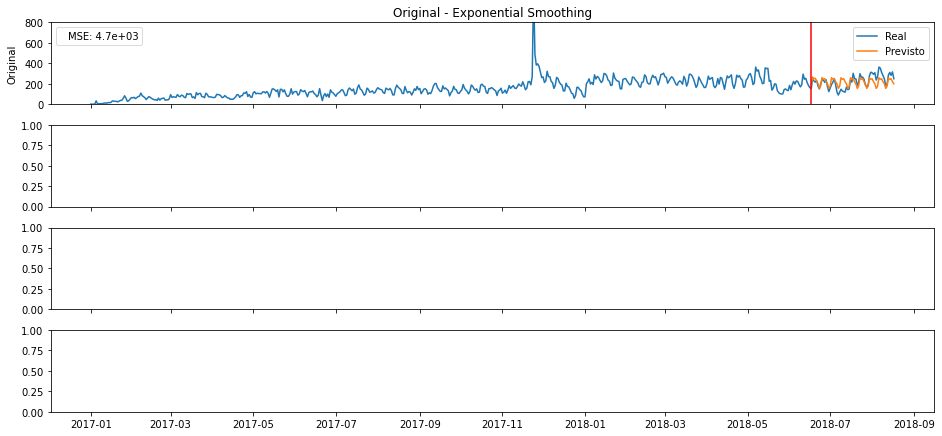

In [56]:
reportES(seriesOriginal.copy(), 'Original', model_kwargs, fit_kwargs, calcPredTestOriginal)

## 3.6 Deseasonal - Exponential Smoothing

#### O código abaixo é uma replicação do item 3.5, de forma que só foi alterado a base de entrada de seriesOriginal para seriesDeseasonal, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [57]:
%%time

if EXECUTE_GRID_SEARCH:
    alphas = betas = gammas = damping_trend = np.arange(1, step = 0.1)
    hyperparam = pd.DataFrame(product(alphas, betas, gammas, damping_trend), columns = ['alpha', 'beta', 'gamma', 'damping_trend'])
    
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSES(seriesDeseasonal.copy(), 'seriesDeseasonal',\
                                                x.alpha, x.beta, x.gamma, x.damping_trend, calcPredTestseriesDeseasonal), axis = 1)
    
    display(hyperparam.query('mse == mse.min() and mse != -1'))

CPU times: total: 0 ns
Wall time: 0 ns


In [58]:
%%time
if EXECUTE_GRID_SEARCH:
    params_ = exp_smoothing_configs([FEATURES])
    hyperparam_ = pd.DataFrame(params_, columns = ['trend', 'season', 'periods', 'bias', 'method'])
    
    hyperparam_['mse'] = hyperparam_.swifter.apply(lambda x: GSESOPT(seriesDeseasonal.copy(), 'seriesDeseasonal',\
                                                     x.trend, x.season, x.periods, x.bias, x.method, calcPredTestseriesDeseasonal),\
                                   axis = 1)
    
    display(hyperparam_.query('mse == mse.min() and mse != -1'))

CPU times: total: 0 ns
Wall time: 0 ns


In [59]:
model_kwargs = dict(trend = 'add', seasonal = 'add', seasonal_periods = FEATURES, damped_trend = True)
fit_kwargs = dict(smoothing_level = 0.1, smoothing_trend = 0.2, smoothing_seasonal = 0.5, method = 'ls', damping_trend = 0.8)

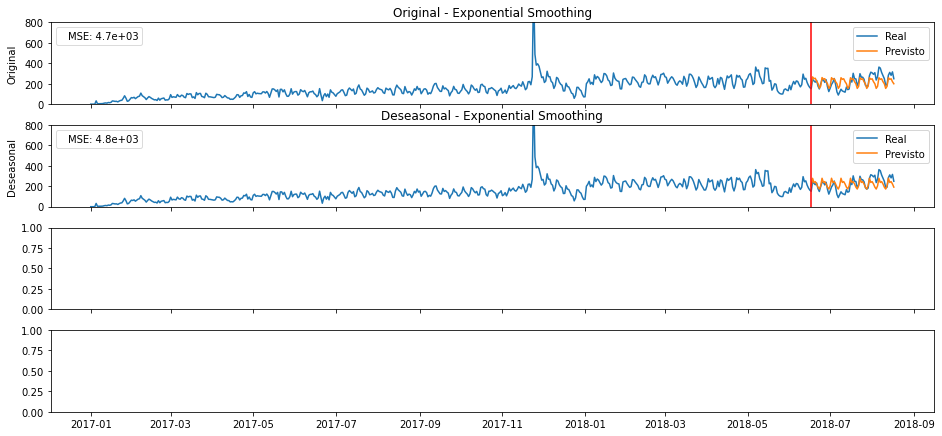

In [60]:
reportES(seriesDeseasonal.copy(), 'Deseasonal', model_kwargs, fit_kwargs, calcPredTestseriesDeseasonal)

## 3.7 BoxCox - Exponential Smoothing

#### O código abaixo é uma replicação do item 3.5, de forma que só foi alterado a base de entrada de seriesOriginal para boxcox, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [61]:
%%time

if EXECUTE_GRID_SEARCH:
    alphas = betas = gammas = damping_trend = np.arange(1, step = 0.1)
    hyperparam = pd.DataFrame(product(alphas, betas, gammas, damping_trend), columns = ['alpha', 'beta', 'gamma', 'damping_trend'])
    
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSES(seriesBoxCox.copy(), 'BoxCox',\
                                                x.alpha, x.beta, x.gamma, x.damping_trend, calcPredTestBoxCox), axis = 1)
    
    display(hyperparam.query('mse == mse.min() and mse != -1'))

CPU times: total: 0 ns
Wall time: 0 ns


In [62]:
%%time
if EXECUTE_GRID_SEARCH:
    params_ = exp_smoothing_configs([FEATURES])
    hyperparam_ = pd.DataFrame(params_, columns = ['trend', 'season', 'periods', 'bias', 'method'])
    
    hyperparam_['mse'] = hyperparam_.swifter.apply(lambda x: GSESOPT(seriesBoxCox.copy(), 'BoxCox',\
                                                  x.trend, x.season, x.periods, x.bias, x.method, calcPredTestBoxCox),\
                                   axis = 1)
    
    display(hyperparam.query('mse == mse.min() and mse != -1'))

CPU times: total: 0 ns
Wall time: 0 ns


In [63]:
model_kwargs = dict(trend = 'add', seasonal = 'add', seasonal_periods = FEATURES, damped_trend = True)
fit_kwargs = dict(smoothing_level = 0.1, smoothing_trend = 0.7, smoothing_seasonal = 0.0, method = 'ls', damping_trend = 0.8)

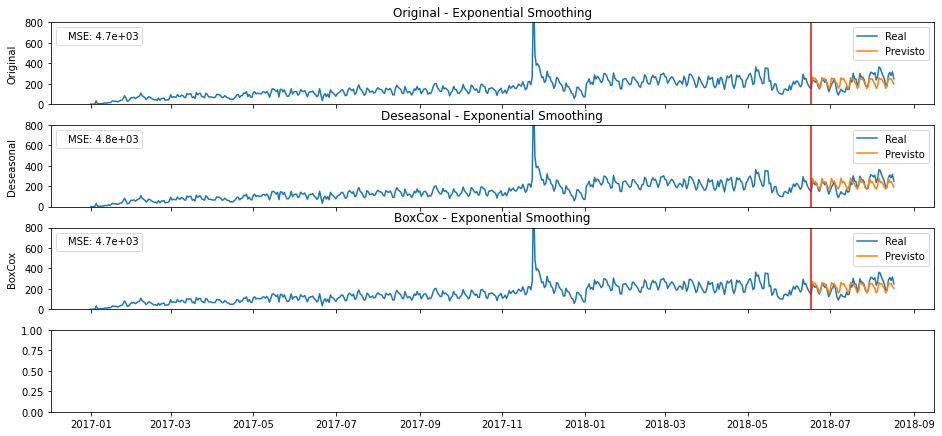

In [64]:
reportES(seriesBoxCox.copy(), 'BoxCox', model_kwargs, fit_kwargs, calcPredTestBoxCox)

## 3.8 Residual - Exponential Smoothing

#### O código abaixo é uma replicação do item 3.5, de forma que só foi alterado a base de entrada de seriesOriginal para seriesResidual, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [65]:
%%time
if EXECUTE_GRID_SEARCH:
    alphas = betas = gammas = damping_trend = np.arange(1, step = 0.1)
    hyperparam = pd.DataFrame(product(alphas, betas, gammas, damping_trend), columns = ['alpha', 'beta', 'gamma', 'damping_trend'])
    
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSES(seriesResidual.copy(), 'Stationary',\
                                                x.alpha, x.beta, x.gamma, x.damping_trend, calcPredTestStationary), axis = 1)
    
    display(hyperparam.query('mse == mse.min() and mse != -1'))

CPU times: total: 0 ns
Wall time: 0 ns


In [66]:
%%time
if EXECUTE_GRID_SEARCH:
    params_ = exp_smoothing_configs([FEATURES])
    
    hyperparam_ = pd.DataFrame(params_, columns = ['trend', 'season', 'periods', 'bias', 'method'])
    
    hyperparam_['mse'] = hyperparam_.swifter.apply(lambda x: GSESOPT(seriesResidual.copy(), 'Stationary',\
                                                  x.trend, x.season, x.periods, x.bias, x.method, calcPredTestStationary),\
                                   axis = 1)
    
    display(hyperparam_.query('mse == mse.min() and mse != -1'))

CPU times: total: 0 ns
Wall time: 0 ns


In [67]:
model_kwargs = dict(trend = 'add', seasonal = 'add', seasonal_periods = FEATURES, damped_trend = True)
fit_kwargs = dict(smoothing_level = 0.0, smoothing_trend = 0.2, smoothing_seasonal = 0.1, method = 'ls', damping_trend = 0.2)

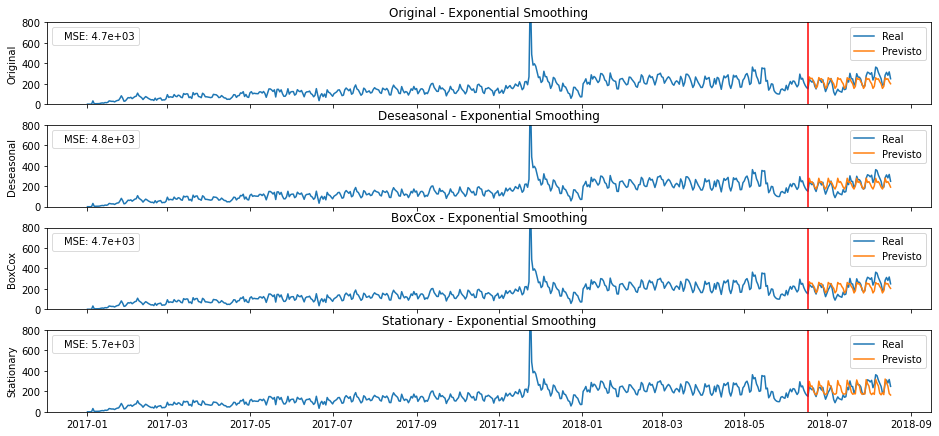

In [68]:
reportES(seriesResidual.copy(), 'Stationary', model_kwargs, fit_kwargs, calcPredTestStationary)

In [69]:
result

Algorithm          MSE       RMSE        MAE  \
0    Original - Time Series Regression  5296.329792  60.784585  42.960631   
1  Deseasonal - Time Series Regression   5081.77776  58.208746  40.122247   
2      BoxCox - Time Series Regression  5328.602465  61.060147  43.254815   
3  Stationary - Time Series Regression  6057.828087  64.323443  46.538896   
4     Original - Exponential Smoothing   4749.16575  55.864659  38.516078   
5   Deseasonal - Exponential Smoothing  4774.382728    55.5275  37.488666   
6       BoxCox - Exponential Smoothing  4653.246578  54.946508  37.555881   
7   Stationary - Exponential Smoothing  5658.627242   63.86568  43.658278   

        MAPE Mean_True_Value Mean_Predict_Value  
0  25.553663      179.560484         168.008596  
1  23.488563      179.560484         164.670085  
2  25.416806      179.560484         165.399796  
3  27.899678      179.560484         184.267746  
4  22.095183      179.560484         165.919136  
5    21.8423      179.560484         166.749778  
6   21.63599      179.560484         166.093056  
7  26.080376      179.560484         179.444886

## 3.9 ARIMA

In [70]:
# Report do algoritmo arima, também é adicionado a base de resultados e realizado o plot de acompanhamento
def reportArima(arimaModel, modelName, calcFunction):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mape = []
    mtv = []
    mpv = []
    
    title = modelName + ' - Auto Arima'
    indexPlot = 0
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        arimaModel.fit(train)
        pred = arimaModel.predict(test.shape[0])
             
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse, rmse, mae, mape, mtv, mpv = calculate_metrics_on(test, pred, mse, rmse, mae, mape, mtv, mpv)
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mape), np.mean(mtv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [71]:
# Reset da figura
figs, axs = plt.subplots(nrows = 4, sharex = True, figsize = (13,6))
figs.align_ylabels()
figs.tight_layout()
plt.close()

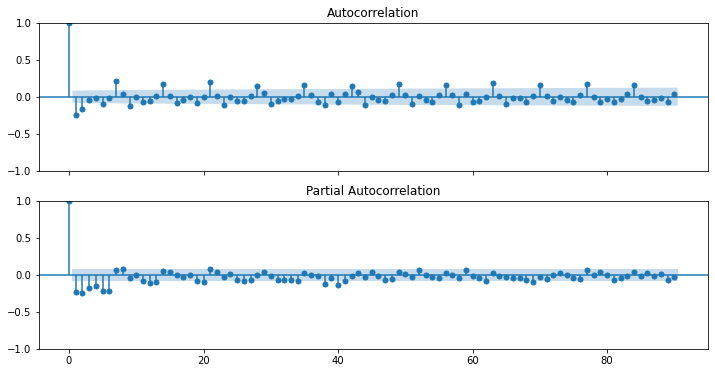

In [72]:
# Correlação entre os periodos com ARIMA

lags = 90

with catch_warnings():
    filterwarnings('ignore')
    fig, ax = plt.subplots(2, figsize = (12, 6), sharex = True)
    plot_acf(seriesOriginal.diff().dropna(), ax = ax[0], lags = lags, missing = 'drop')
    plot_pacf(seriesOriginal.diff().dropna(), ax = ax[1], lags = lags)
    plt.show()

In [73]:
%%time

# Utilizando o auto arima para descobrir os argumentos ideias baseados no conjunto de dado informado
data = seriesOriginal.copy()
arimaModel = auto_arima(seriesOriginal.copy(), m = FEATURES, seasonal = True)
arimaModel

CPU times: total: 22.8 s
Wall time: 22.5 s


ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(0, 0, 2, 7),
      suppress_warnings=True)

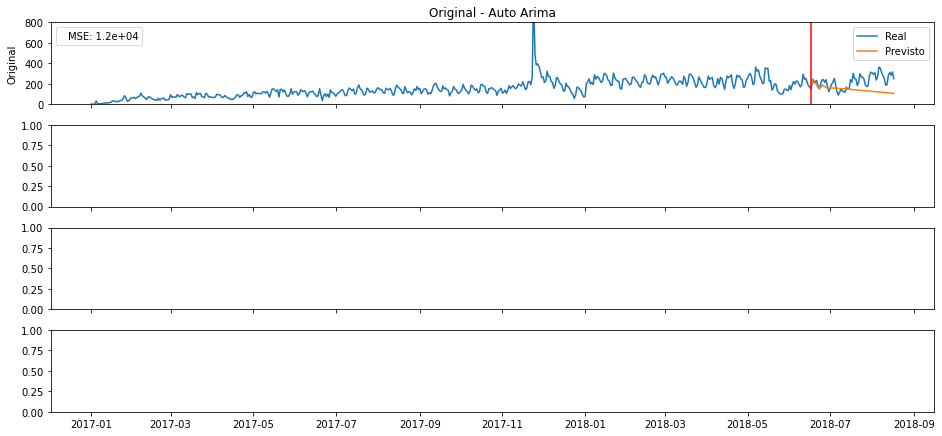

In [74]:
reportArima(arimaModel, 'Original', calcPredTestOriginal)

## 3.10 Deseasonal - ARIMA

#### O código abaixo é uma replicação do item 3.9, de forma que só foi alterado a base de entrada de seriesOriginal para seriesDeseasonal, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [75]:
%%time
data = seriesDeseasonal.copy()
arimaModel = auto_arima(data, m = FEATURES, seasonal = False)
arimaModel

C:\Users\herik\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (7) set for non-seasonal fit. Setting to 0



CPU times: total: 2.53 s
Wall time: 2.63 s


ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

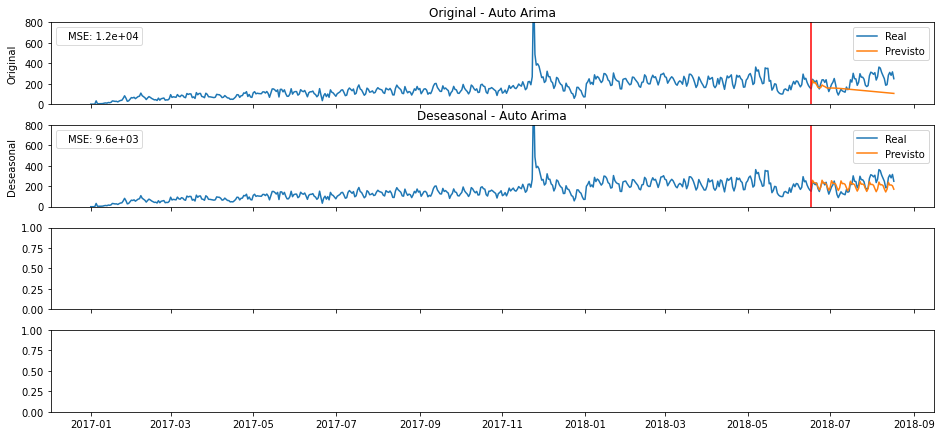

In [76]:
reportArima(arimaModel, 'Deseasonal', calcPredTestseriesDeseasonal)

## 3.11 BoxCox - ARIMA

#### O código abaixo é uma replicação do item 3.9, de forma que só foi alterado a base de entrada de seriesOriginal para boxcox, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [77]:
%%time
data = seriesBoxCox.copy()
arimaModel = auto_arima(data, m = FEATURES, seasonal = True)
arimaModel

CPU times: total: 26.8 s
Wall time: 26.9 s


ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

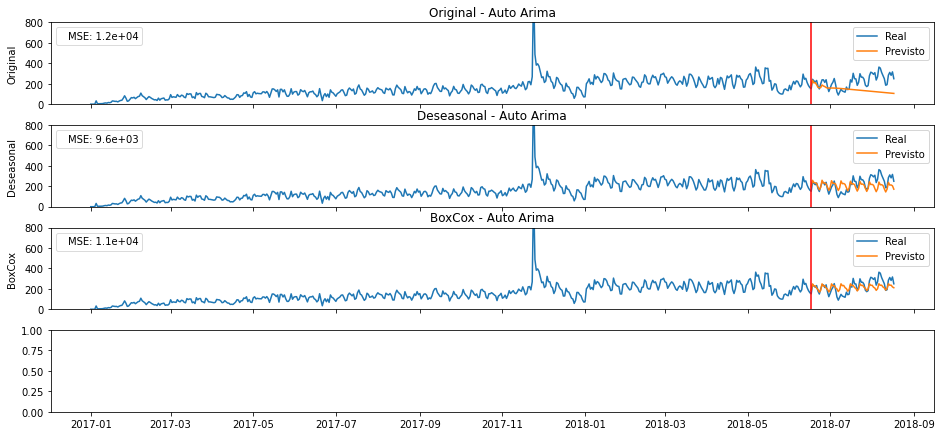

In [78]:
reportArima(arimaModel, 'BoxCox', calcPredTestBoxCox)

## 3.12 Residual - ARIMA

#### O código abaixo é uma replicação do item 3.9, de forma que só foi alterado a base de entrada original para stationary, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [79]:
%%time
data = seriesResidual.copy()
arimaModel = auto_arima(data, m = FEATURES, seasonal = False)
arimaModel

C:\Users\herik\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (7) set for non-seasonal fit. Setting to 0



CPU times: total: 5.92 s
Wall time: 6 s


ARIMA(order=(3, 0, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

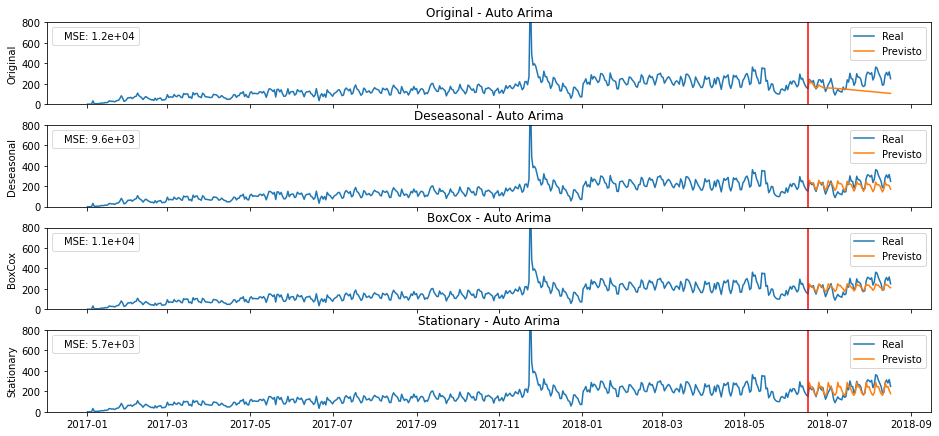

In [80]:
reportArima(arimaModel, 'Stationary', calcPredTestStationary)

In [81]:
result

Algorithm           MSE       RMSE        MAE  \
0     Original - Time Series Regression   5296.329792  60.784585  42.960631   
1   Deseasonal - Time Series Regression    5081.77776  58.208746  40.122247   
2       BoxCox - Time Series Regression   5328.602465  61.060147  43.254815   
3   Stationary - Time Series Regression   6057.828087  64.323443  46.538896   
4      Original - Exponential Smoothing    4749.16575  55.864659  38.516078   
5    Deseasonal - Exponential Smoothing   4774.382728    55.5275  37.488666   
6        BoxCox - Exponential Smoothing   4653.246578  54.946508  37.555881   
7    Stationary - Exponential Smoothing   5658.627242   63.86568  43.658278   
8                 Original - Auto Arima  11599.889603  89.225015   70.61781   
9               Deseasonal - Auto Arima   9591.302944  77.051189  59.640244   
10                  BoxCox - Auto Arima  11393.604917  84.409223   66.06974   
11              Stationary - Auto Arima   5675.808118  62.612956  43.570659   

         MAPE Mean_True_Value Mean_Predict_Value  
0   25.553663      179.560484         168.008596  
1   23.488563      179.560484         164.670085  
2   25.416806      179.560484         165.399796  
3   27.899678      179.560484         184.267746  
4   22.095183      179.560484         165.919136  
5     21.8423      179.560484         166.749778  
6    21.63599      179.560484         166.093056  
7   26.080376      179.560484         179.444886  
8   42.311848      179.560484         194.668305  
9   35.253536      179.560484         191.568473  
10  39.346984      179.560484         206.496282  
11  25.453974      179.560484          169.27759

## 3.13 LSTM

In [82]:
# Redefinindo variaveis globais para o treino utilizando LSTM

BATCH_SIZE = 30

In [83]:
# hypertuning do algoritmo de LSTM
def GSLSTM(data, learning_rate, calcFunction):
    mse = []
    
    # Crossvalidation para cada parte do conjunto
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]

        try:
            with catch_warnings():
                filterwarnings('ignore')
                
                # Normalização e reshape do conjunto de treino
                ss = StandardScaler()
                ss.fit(train.values.reshape(-1, 1))
                train_input = ss.transform(train.values.reshape(-1, 1))
                
                # Gerando conjunto de treino com TimeseriesGenerator baseado no conjunto atual e o batch informado
                test_input = train_input[-(FEATURES + 1):]
                test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)
                train_gen = TimeseriesGenerator(train_input, train_input, length = FEATURES, batch_size = BATCH_SIZE)
                
                # Reset da sessão
                clear_session()
                
                # Construindo o modelo de LSTM com GlorotUniform pois inicializa de forma normalizada
                initializer = GlorotUniform(seed = SEED)
                model = Sequential()
                
                # 1 camada de LSTM com 64 entradas, 2 camadas densas e uma de normalização intermediando as camadas densas
                model.add(LSTM(64, input_shape = (FEATURES, 1), return_sequences = False))
                model.add(Dense(1, kernel_initializer = initializer))
                model.add(BatchNormalization())
                model.add(Dense(1, kernel_initializer = initializer))
                
                # Configurando o EarlyStopping para o modelo não treinar mais que 3x seguidas se não obtiver melhorias nos resultados
                early_stopping = EarlyStopping(monitor = 'loss', patience = 3, mode = 'min')
                
                # Treinando o modelo com otimizador Adam
                model.compile(loss = 'mse', optimizer = Adam(learning_rate = learning_rate), metrics = ['mae'])
                h = model.fit(train_gen, epochs = EPOCHS, callbacks = [early_stopping], verbose = False)
                pred = np.empty(test.shape[0])
                
                # Realizando predições no conjunto de teste
                for i in range(len(pred)):
                    prediction = model.predict(test_gen, verbose = False)
                    pred[i] = prediction
                    test_input = np.delete(test_input, 0, 0)
                    test_input = np.concatenate((test_input, np.array(prediction).reshape(-1, 1)), axis = 0)
                    test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)
                
                # Reorganizando o shape e chamando a função de calculo
                pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
                pred, test, _ = calcFunction(train, pred, test)      

                mse.append(mean_squared_error(pred, test))
                
        except:
            mse.append(-1)
        
    return np.mean(mse)

In [84]:
# Report do algoritmo LSTM
def reportLSTM(data, modelName, calcFunction, learning_rate):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mape = []
    mtv = []
    mpv = []
    
    title = modelName + ' - Long Short Term Memory (LSTM)'
    
    # Crossvalidation para cada parte do conjunto
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
    
        # Normalização e reshape do conjunto de treino
        ss = StandardScaler()
        ss.fit(train.values.reshape(-1, 1))
        train_input = ss.transform(train.values.reshape(-1, 1))

        # Gerando conjunto de treino com TimeseriesGenerator baseado no conjunto atual e o batch informado
        test_input = train_input[-(FEATURES + 1):]
        test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)
        train_gen = TimeseriesGenerator(train_input, train_input, length = FEATURES, batch_size = BATCH_SIZE)

        # Reset da sessão
        clear_session()
        
        # Construindo o modelo de LSTM com GlorotUniform pois inicializa de forma normalizada
        initializer = GlorotUniform(seed = SEED)
        model = Sequential()
        
        # 1 camada de LSTM com 64 entradas, 2 camadas densas e uma de normalização intermediando as camadas densas
        model.add(LSTM(64, input_shape = (FEATURES, 1), return_sequences = False))
        model.add(Dense(1, kernel_initializer = initializer))
        model.add(BatchNormalization())
        model.add(Dense(1, kernel_initializer = initializer))
        
        # Configurando o EarlyStopping para o modelo não treinar mais que 3x seguidas se não obtiver melhorias nos resultados
        early_stopping = EarlyStopping(monitor = 'loss', patience = 3, mode = 'min')
        
        # Treinando o modelo com otimizador Adam
        model.compile(loss = 'mse', optimizer = Adam(learning_rate = learning_rate), metrics = ['mae'])
        h = model.fit(train_gen, epochs = EPOCHS, callbacks = [early_stopping], verbose = False)
        pred = np.empty(test.shape[0])

        # Realizando predições no conjunto de teste
        for i in range(len(pred)):
            prediction = model.predict(test_gen, verbose = False)
            pred[i] = prediction
            test_input = np.delete(test_input, 0, 0)
            test_input = np.concatenate((test_input, np.array(prediction).reshape(-1, 1)), axis = 0)
            test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)

        # Reorganizando o shape e chamando a função de calculo
        pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse, rmse, mae, mape, mtv, mpv = calculate_metrics_on(test, pred, mse, rmse, mae, mape, mtv, mpv)
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mape), np.mean(mtv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [85]:
%%time
if EXECUTE_GRID_SEARCH:
    # Gerando tabela de hypertunning com taxas de learning_rate
    learning_rates = np.logspace(-5, 1, 7)
    hyperparam = pd.DataFrame(learning_rates, columns = ['learning_rate'])
    
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSLSTM(seriesOriginal.copy(), x.learning_rate, calcPredTestOriginal), axis = 1)
    
    display(hyperparam.query('mse == mse.min() and mse != -1'))

CPU times: total: 0 ns
Wall time: 0 ns


In [86]:
# Reset da figura
figs, axs = plt.subplots(nrows = 4, sharex = True, figsize = (13,6))
figs.align_ylabels()
figs.tight_layout()
plt.close()

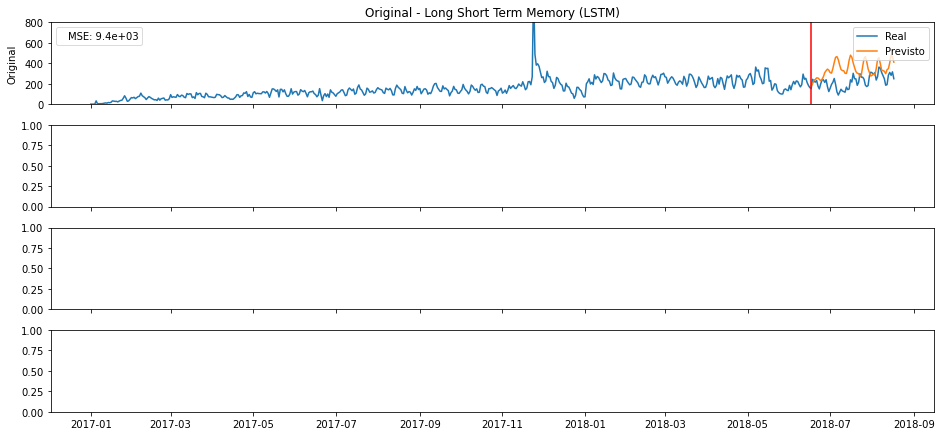

In [87]:
reportLSTM(seriesOriginal.copy(), 'Original', calcPredTestOriginal, 0.0001)

## 3.14 Deseasonal - LSTM

#### O código abaixo é uma replicação do item 3.13, de forma que só foi alterado a base de entrada original para seriesDeseasonal, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [88]:
%%time

if EXECUTE_GRID_SEARCH:
    learning_rates = np.logspace(-5, 1, 7)
    hyperparam = pd.DataFrame(learning_rates, columns = ['learning_rate'])
    
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSLSTM(seriesDeseasonal.copy(), x.learning_rate, calcPredTestseriesDeseasonal), axis = 1)
    
    display(hyperparam.query('mse == mse.min() and mse != -1'))

CPU times: total: 0 ns
Wall time: 0 ns


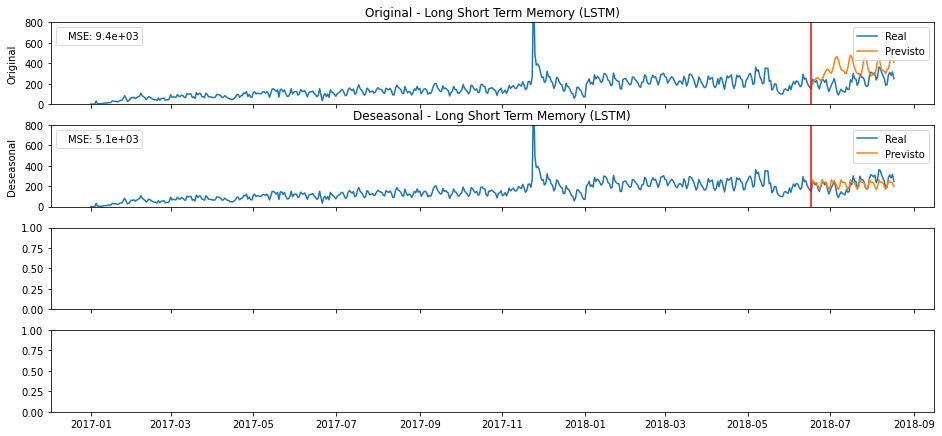

In [89]:
reportLSTM(seriesDeseasonal.copy(), 'Deseasonal', calcPredTestseriesDeseasonal, 0.01)

## 3.15 BoxCox - LSTM

#### O código abaixo é uma replicação do item 3.13, de forma que só foi alterado a base de entrada original para boxcox, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [90]:
%%time

if EXECUTE_GRID_SEARCH:
    learning_rates = np.logspace(-5, 1, 7)
    hyperparam = pd.DataFrame(learning_rates, columns = ['learning_rate'])
    
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSLSTM(seriesBoxCox.copy(), x.learning_rate, calcPredTestBoxCox), axis = 1)
    
    display(hyperparam.query('mse == mse.min() and mse != -1'))

CPU times: total: 0 ns
Wall time: 999 µs


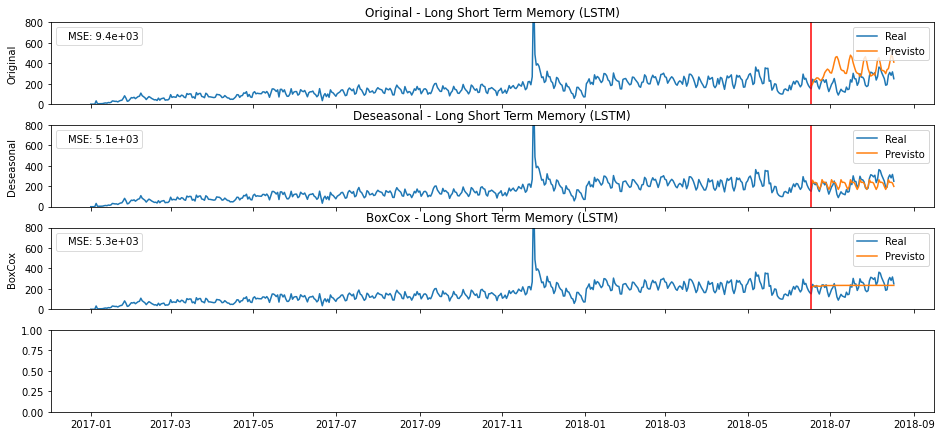

In [91]:
reportLSTM(seriesBoxCox.copy(), 'BoxCox', calcPredTestBoxCox, 0.001)

## 3.16 Residual - LSTM

#### O código abaixo é uma replicação do item 3.13, de forma que só foi alterado a base de entrada original para stationary, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [92]:
%%time

if EXECUTE_GRID_SEARCH:
    learning_rates = np.logspace(-5, 1, 7)
    hyperparam = pd.DataFrame(learning_rates, columns = ['learning_rate'])
    
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSLSTM(seriesResidual.copy(), x.learning_rate, calcPredTestStationary), axis = 1)
    
    display(hyperparam.query('mse == mse.min() and mse != -1'))

CPU times: total: 0 ns
Wall time: 1 ms


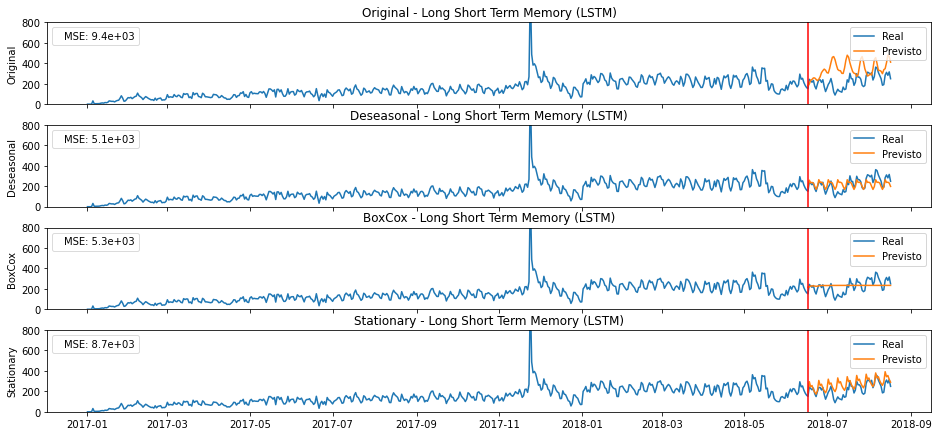

In [93]:
reportLSTM(seriesResidual.copy(), 'Stationary', calcPredTestStationary, 0.00001)

In [94]:
result

Algorithm           MSE       RMSE  \
0            Original - Time Series Regression   5296.329792  60.784585   
1          Deseasonal - Time Series Regression    5081.77776  58.208746   
2              BoxCox - Time Series Regression   5328.602465  61.060147   
3          Stationary - Time Series Regression   6057.828087  64.323443   
4             Original - Exponential Smoothing    4749.16575  55.864659   
5           Deseasonal - Exponential Smoothing   4774.382728    55.5275   
6               BoxCox - Exponential Smoothing   4653.246578  54.946508   
7           Stationary - Exponential Smoothing   5658.627242   63.86568   
8                        Original - Auto Arima  11599.889603  89.225015   
9                      Deseasonal - Auto Arima   9591.302944  77.051189   
10                         BoxCox - Auto Arima  11393.604917  84.409223   
11                     Stationary - Auto Arima   5675.808118  62.612956   
12    Original - Long Short Term Memory (LSTM)   9381.265495  84.147816   
13  Deseasonal - Long Short Term Memory (LSTM)    5064.39062  57.410273   
14      BoxCox - Long Short Term Memory (LSTM)   5325.842935  63.086576   
15  Stationary - Long Short Term Memory (LSTM)    8713.79911  76.748656   

          MAE       MAPE Mean_True_Value Mean_Predict_Value  
0   42.960631  25.553663      179.560484         168.008596  
1   40.122247  23.488563      179.560484         164.670085  
2   43.254815  25.416806      179.560484         165.399796  
3   46.538896  27.899678      179.560484         184.267746  
4   38.516078  22.095183      179.560484         165.919136  
5   37.488666    21.8423      179.560484         166.749778  
6   37.555881   21.63599      179.560484         166.093056  
7   43.658278  26.080376      179.560484         179.444886  
8    70.61781  42.311848      179.560484         194.668305  
9   59.640244  35.253536      179.560484         191.568473  
10   66.06974  39.346984      179.560484         206.496282  
11  43.570659  25.453974      179.560484          169.27759  
12  61.880612   38.23957      179.560484         188.430568  
13  39.893818  23.371864      179.560484         164.653074  
14  44.862384  25.808698      179.560484         159.906651  
15  57.541623  34.481319      179.560484         202.934807

### 3.16 Original - XGBoost Regressor

In [95]:
def create_features(df, label = None):
    # Separando variaveis temporais
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [96]:
# Convertendo dtHistory para serial
dtHistoryIndexado = dtHistory.copy()
dtHistoryIndexado.index = dtHistoryIndexado['Data']
dtHistoryIndexado = dtHistoryIndexado['Vendas']

In [97]:
# Separando base de treino e teste
split_date = '2018-06-16'
train = dtHistoryIndexado.loc[dtHistoryIndexado.index <= split_date].copy()
test = dtHistoryIndexado.loc[dtHistoryIndexado.index > split_date].copy()

# Convertendo base de treio e teste para dataframe
train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [98]:
# Separando X e y em treino e teste
X_train, y_train = create_features(train, label = 'Vendas')
X_test, y_test = create_features(test, label = 'Vendas')

In [99]:
# Treinando modelo
model = XGBRegressor(n_estimators = 1000, early_stopping_rounds = 10, objective = 'reg:squarederror')
model.fit(X_train, y_train,
        eval_set = [(X_train, y_train)],
        verbose = True)

[0]	validation_0-rmse:128.20663
[1]	validation_0-rmse:94.86369
[2]	validation_0-rmse:71.45047
[3]	validation_0-rmse:54.90688
[4]	validation_0-rmse:43.03469
[5]	validation_0-rmse:34.67400
[6]	validation_0-rmse:28.38199
[7]	validation_0-rmse:23.87289
[8]	validation_0-rmse:20.62290
[9]	validation_0-rmse:18.05469
[10]	validation_0-rmse:16.07627
[11]	validation_0-rmse:14.50070
[12]	validation_0-rmse:13.32707
[13]	validation_0-rmse:12.46696
[14]	validation_0-rmse:11.73353
[15]	validation_0-rmse:11.21462
[16]	validation_0-rmse:10.89039
[17]	validation_0-rmse:10.55919
[18]	validation_0-rmse:10.25021
[19]	validation_0-rmse:10.05513
[20]	validation_0-rmse:9.81996
[21]	validation_0-rmse:9.37028
[22]	validation_0-rmse:9.13984
[23]	validation_0-rmse:9.05815
[24]	validation_0-rmse:8.90733
[25]	validation_0-rmse:8.58755
[26]	validation_0-rmse:8.32837
[27]	validation_0-rmse:8.09972
[28]	validation_0-rmse:7.90257
[29]	validation_0-rmse:7.56035
[30]	validation_0-rmse:7.28918
[31]	validation_0-rmse:7.117

[259]	validation_0-rmse:0.20474
[260]	validation_0-rmse:0.20149
[261]	validation_0-rmse:0.20013
[262]	validation_0-rmse:0.19902
[263]	validation_0-rmse:0.19648
[264]	validation_0-rmse:0.19528
[265]	validation_0-rmse:0.19469
[266]	validation_0-rmse:0.18881
[267]	validation_0-rmse:0.18798
[268]	validation_0-rmse:0.18735
[269]	validation_0-rmse:0.18524
[270]	validation_0-rmse:0.18483
[271]	validation_0-rmse:0.18418
[272]	validation_0-rmse:0.17883
[273]	validation_0-rmse:0.17609
[274]	validation_0-rmse:0.17414
[275]	validation_0-rmse:0.16952
[276]	validation_0-rmse:0.16754
[277]	validation_0-rmse:0.16581
[278]	validation_0-rmse:0.16290
[279]	validation_0-rmse:0.16119
[280]	validation_0-rmse:0.15860
[281]	validation_0-rmse:0.15652
[282]	validation_0-rmse:0.15257
[283]	validation_0-rmse:0.15240
[284]	validation_0-rmse:0.15080
[285]	validation_0-rmse:0.14820
[286]	validation_0-rmse:0.14598
[287]	validation_0-rmse:0.14231
[288]	validation_0-rmse:0.14112
[289]	validation_0-rmse:0.14066
[290]	va

[516]	validation_0-rmse:0.00733
[517]	validation_0-rmse:0.00722
[518]	validation_0-rmse:0.00721
[519]	validation_0-rmse:0.00720
[520]	validation_0-rmse:0.00707
[521]	validation_0-rmse:0.00695
[522]	validation_0-rmse:0.00683
[523]	validation_0-rmse:0.00674
[524]	validation_0-rmse:0.00670
[525]	validation_0-rmse:0.00669
[526]	validation_0-rmse:0.00663
[527]	validation_0-rmse:0.00662
[528]	validation_0-rmse:0.00662
[529]	validation_0-rmse:0.00659
[530]	validation_0-rmse:0.00658
[531]	validation_0-rmse:0.00655
[532]	validation_0-rmse:0.00637
[533]	validation_0-rmse:0.00635
[534]	validation_0-rmse:0.00618
[535]	validation_0-rmse:0.00616
[536]	validation_0-rmse:0.00611
[537]	validation_0-rmse:0.00598
[538]	validation_0-rmse:0.00597
[539]	validation_0-rmse:0.00589
[540]	validation_0-rmse:0.00575
[541]	validation_0-rmse:0.00568
[542]	validation_0-rmse:0.00558
[543]	validation_0-rmse:0.00557
[544]	validation_0-rmse:0.00547
[545]	validation_0-rmse:0.00544
[546]	validation_0-rmse:0.00539
[547]	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

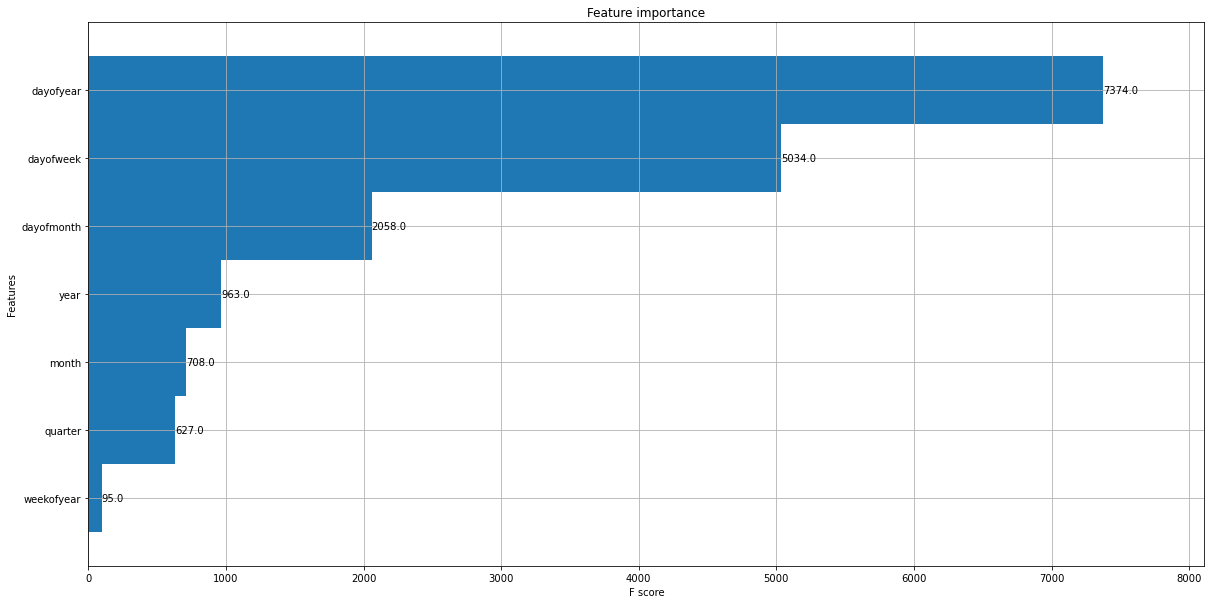

In [100]:
plot_importance(model, height = 1)

In [101]:
test['Previsões'] = model.predict(X_test)
XGBresults = pd.concat([test, train], sort = False)

In [102]:
pred = test['Previsões']
test_ = test['Vendas']

In [103]:
mse, rmse, mae, mape, mtv, mpv = calculate_metrics_off(test_, pred)

In [104]:
result = record(result, 'Original - XGBoost', mse, rmse, mae, mape, mtv, mpv, False)

In [105]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = seriesOriginal.index,
                        y = seriesOriginal,
                        name = 'Real'),
             go.Scatter(x = test.index,
                        y = test['Previsões'],
                        name = 'Previsto')]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Período'},
                        yaxis = {'title': 'Vendas'}, 
                        title = 'Original - XGBoost')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

fig.add_vrect(x0 = '2018-06-17', x1 = '2018-08-17', 
              annotation_text = 'Previsão base<br>de teste', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'orange', opacity = 0.2, line_width = 0)

pyoff.iplot(fig)

In [106]:
result

Algorithm           MSE       RMSE  \
0            Original - Time Series Regression   5296.329792  60.784585   
1          Deseasonal - Time Series Regression    5081.77776  58.208746   
2              BoxCox - Time Series Regression   5328.602465  61.060147   
3          Stationary - Time Series Regression   6057.828087  64.323443   
4             Original - Exponential Smoothing    4749.16575  55.864659   
5           Deseasonal - Exponential Smoothing   4774.382728    55.5275   
6               BoxCox - Exponential Smoothing   4653.246578  54.946508   
7           Stationary - Exponential Smoothing   5658.627242   63.86568   
8                        Original - Auto Arima  11599.889603  89.225015   
9                      Deseasonal - Auto Arima   9591.302944  77.051189   
10                         BoxCox - Auto Arima  11393.604917  84.409223   
11                     Stationary - Auto Arima   5675.808118  62.612956   
12    Original - Long Short Term Memory (LSTM)   9381.265495  84.147816   
13  Deseasonal - Long Short Term Memory (LSTM)    5064.39062  57.410273   
14      BoxCox - Long Short Term Memory (LSTM)   5325.842935  63.086576   
15  Stationary - Long Short Term Memory (LSTM)    8713.79911  76.748656   
16                          Original - XGBoost   5021.661691  70.863684   

          MAE       MAPE Mean_True_Value Mean_Predict_Value  
0   42.960631  25.553663      179.560484         168.008596  
1   40.122247  23.488563      179.560484         164.670085  
2   43.254815  25.416806      179.560484         165.399796  
3   46.538896  27.899678      179.560484         184.267746  
4   38.516078  22.095183      179.560484         165.919136  
5   37.488666    21.8423      179.560484         166.749778  
6   37.555881   21.63599      179.560484         166.093056  
7   43.658278  26.080376      179.560484         179.444886  
8    70.61781  42.311848      179.560484         194.668305  
9   59.640244  35.253536      179.560484         191.568473  
10   66.06974  39.346984      179.560484         206.496282  
11  43.570659  25.453974      179.560484          169.27759  
12  61.880612   38.23957      179.560484         188.430568  
13  39.893818  23.371864      179.560484         164.653074  
14  44.862384  25.808698      179.560484         159.906651  
15  57.541623  34.481319      179.560484         202.934807  
16    61.2467  29.323271      221.854839         192.635712

## 4. Comparação

In [107]:
# Tratando nomes e criando colunas de controle para os resultados gerados
topResult = (
    result 
    .assign(Full_Name = lambda x: x.Algorithm.apply(lambda a: a.split('(')[0]
                                                   .replace('ARIMA', 'Auto Arima')
                                                   .replace('Long Short Term Memory', 'LSTM')))
    .assign(Data_Category = lambda x: x.Algorithm.apply(lambda a: a.split(' - ')[0]))
    .assign(Algorithm = lambda x: x.Algorithm.apply(lambda a: a.split(' - ')[1].split('(')[0]
                                                   .replace('ARIMA', 'Auto Arima')
                                                   .replace('Long Short Term Memory', 'LSTM')))
    .sort_values('MSE')
)

In [111]:
topResult.head()

Algorithm          MSE       RMSE        MAE       MAPE  \
6   Exponential Smoothing  4653.246578  54.946508  37.555881   21.63599   
4   Exponential Smoothing   4749.16575  55.864659  38.516078  22.095183   
5   Exponential Smoothing  4774.382728    55.5275  37.488666    21.8423   
16                XGBoost  5021.661691  70.863684    61.2467  29.323271   
13                  LSTM    5064.39062  57.410273  39.893818  23.371864   

   Mean_True_Value Mean_Predict_Value                           Full_Name  \
6       179.560484         166.093056      BoxCox - Exponential Smoothing   
4       179.560484         165.919136    Original - Exponential Smoothing   
5       179.560484         166.749778  Deseasonal - Exponential Smoothing   
16      221.854839         192.635712                  Original - XGBoost   
13      179.560484         164.653074                  Deseasonal - LSTM    

   Data_Category  
6         BoxCox  
4       Original  
5     Deseasonal  
16      Original  
13    Deseasonal

In [116]:
# Plot dos resultados obtidos por ordem ascendente do MSE

colors = {'Time Series Regression':'#1688F2',
          'Exponential Smoothing':'#17FC2E',
          'Auto Arima': '#E6C220',
          'LSTM ': '#FC4417',
           'XGBoost': '#A13BF5'}

# plotly figure
fig = go.Figure(layout = go.Layout(yaxis = {'type': 'category', 'title': 'Algoritmo e Categoria'},
                        xaxis = {'title': 'MSE'},
                        title = 'MSE por Algoritmo e Tipo de Dado'))

for t in topResult['Algorithm'].unique():
    topResultFiltered = topResult[topResult['Algorithm']== t].copy()
    fig.add_traces(go.Bar(x = topResultFiltered['MSE'], y = topResultFiltered['Full_Name'], name = str(t),\
                          marker_color = str(colors[t]), orientation = 'h',
                          text = round(topResultFiltered['MSE'].astype(np.double)), textposition = 'outside'))
    
    
fig.update_layout(yaxis = {'categoryorder':'total descending'}, autosize = False,
                  width = 1450,
                  height = 800)
    
fig.show()

## 4. Previsões Futuras

In [117]:
pred_range = pd.date_range(datetime.date(2018, 6, 17), datetime.date(2018, 10, 31))
split_range = TimeSeriesSplit(n_splits = 2, max_train_size = pred_range.shape[0], test_size = pred_range.shape[0])

### 4.1 BoxCox - Exponential Smoothing

In [118]:
BATCH_SIZE = 1000

In [119]:
# Alocando melhor modelo a memória e separando base de treino
data = seriesBoxCox.copy()
train = data[datetime.date(2017, 1, 1): datetime.date(2018, 6, 16)]

In [120]:
# Treinando modelo baseado dos parâmetros descobertos na fase de modelagem
ES = (
    ExponentialSmoothing(train, trend = 'add', seasonal = 'add', seasonal_periods = FEATURES, damped_trend = True)
    .fit(smoothing_level = 0.1, smoothing_trend = 0.7, smoothing_seasonal = 0.0, method = 'ls', damping_trend = 0.8)
)

In [121]:
# Calculando a previsão até o final do ano de 2018
pred = ES.predict(str(data.index[0]), '2018-12-31')
pred, data, _ = calcPredTestBoxCox(train, pred, data)  

In [122]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = seriesOriginal.index,
                        y = seriesOriginal,
                        name = 'Real'),
             go.Scatter(x = pred.index,
                        y = pred,
                        name = 'Previsto')]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Período'},
                        yaxis = {'title': 'Vendas'}, 
                        title = 'BoxCox - Exponential Smoothing')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

fig.add_vrect(x0 = '2018-06-17', x1 = '2018-08-17', 
              annotation_text = 'Previsão base<br>de teste', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'orange', opacity = 0.2, line_width = 0)

fig.add_vrect(x0 = '2018-08-17', x1 = '2018-12-31', 
              annotation_text = 'Projeção de<br>Vendas Futuras', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'green', opacity = 0.2, line_width = 0)

fig.update_layout(yaxis_range = [0 , 800])

pyoff.iplot(fig)

In [123]:
ES.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                     None   No. Observations:                  532
Model:             ExponentialSmoothing   SSE                           7800.497
Optimized:                         True   AIC                           1452.579
Trend:                         Additive   BIC                           1503.899
Seasonal:                      Additive   AICC                          1453.392
Seasonal Periods:                     7   Date:                 Sun, 09 Oct 2022
Box-Cox:                          False   Time:                         13:54:28
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha                False
smoothing_trend               0.7000000                 beta                False
smoothing_seasonal             0.000000                gamma                False
initial_level                -5.0438933                  l.0                 True
initial_trend                 1.3021823                  b.0                 True
damping_trend                 0.8000000                  phi                False
initial_seasons.0             0.5899851                  s.0                 True
initial_seasons.1             4.8396236                  s.1                 True
initial_seasons.2             4.7464382                  s.2                 True
initial_seasons.3             4.2431176                  s.3                 True
initial_seasons.4             3.6034685                  s.4                 True
initial_seasons.5             2.5651724                  s.5                 True
initial_seasons.6            -0.7669847                  s.6                 True
---------------------------------------------------------------------------------
"""

In [124]:
# Alocando melhor modelo a memória e separando base de treino
data = seriesBoxCox.copy()
train = data[datetime.date(2017, 1, 1): datetime.date(2018, 6, 16)]

# Treinando modelo baseado dos parâmetros descobertos na fase de modelagem
ES = (
    ExponentialSmoothing(train, trend = 'add', seasonal = 'add', seasonal_periods = FEATURES, damped_trend = True)
    .fit(smoothing_level = 0.1, smoothing_trend = 0.7, smoothing_seasonal = 0.0, method = 'ls', damping_trend = 0.8)
)

# Calculando a previsão até o final do ano de 2018
pred = ES.predict(str(data.index[0]), '2018-08-17')
pred, data, _ = calcPredTestBoxCox(train, pred, data)

In [125]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = data.index,
                        y = data,
                        name = 'Real'),
             go.Scatter(x = data.index,
                        y = pred,
                        name = 'Previsto', fill = "tonexty")]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Período'},
                        yaxis = {'title': 'Vendas'}, 
                        title = 'Deseasonal - Exponential Smoothing')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

fig.update_layout(yaxis_range = [0 , 800])

pyoff.iplot(fig)

In [126]:
tempIndex = pd.date_range(datetime.date(2017, 1, 1), datetime.date(2017, 11, 20))

In [127]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = tempIndex,
                        y = data,
                        name = 'Real'),
             go.Scatter(x = tempIndex,
                        y = pred,
                        name = 'Previsto', fill = "tonexty")]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Período'},
                        yaxis = {'title': 'Vendas'}, 
                        title = 'Deseasonal - Exponential Smoothing')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

pyoff.iplot(fig)

In [128]:
tempIndex = pd.date_range(datetime.date(2017, 1, 1), datetime.date(2017, 12, 31))

In [129]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = tempIndex,
                        y = data,
                        name = 'Real'),
             go.Scatter(x = tempIndex,
                        y = pred,
                        name = 'Previsto', fill = "tonexty")]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Período'},
                        yaxis = {'title': 'Vendas'}, 
                        title = 'Deseasonal - Exponential Smoothing')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

fig.update_layout(yaxis_range = [0 , 800])

pyoff.iplot(fig)

In [130]:
tempIndex = pd.date_range(datetime.date(2018, 1, 1), datetime.date(2018, 8, 17))

In [131]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = tempIndex,
                        y = data,
                        name = 'Real'),
             go.Scatter(x = tempIndex,
                        y = pred,
                        name = 'Previsto', fill = "tonexty")]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Período'},
                        yaxis = {'title': 'Vendas'}, 
                        title = 'Deseasonal - Exponential Smoothing')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

fig.add_vrect(x0 = '2018-06-17', x1 = '2018-08-17', 
              annotation_text = 'Previsão base<br>de teste', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'orange', opacity = 0.2, line_width = 0)

pyoff.iplot(fig)

### 4.2 Deseasonal - LSTM

In [132]:
BATCH_SIZE = 30

In [133]:
# Definindo dataset
dtHistoryLSTM = pd.to_datetime(dtOrdersAdjusted['order_purchase_timestamp']).dt.date

# Separando periodo minimo e maximo
startLSTM = dtHistoryLSTM.min()
endLSTM = dtHistoryLSTM.max()

# Separando IDs das lacunas
idxLSTM = pd.date_range(startLSTM, endLSTM, normalize = True)

# Transformando dt para série e realizando contagem de valores diários
seriesOriginalLSTM = dtHistoryLSTM.value_counts(sort = False).sort_index().reindex(idxLSTM, fill_value = 0)

# Removendo outliers
seriesOriginalLSTM = seriesOriginalLSTM[datetime.date(2017, 1, 1): datetime.date(2018, 8, 17)]

# Adicionando  predições futuras
newPredictions = pd.Series([0 for i in range(136)])
newPredictions.index = pd.date_range(datetime.date(2018, 8, 18), datetime.date(2018, 12, 31))
seriesOriginalTSTRPredictions = seriesOriginalLSTM.append(newPredictions)

# Gerando STL para separar o Deseasonal
stl = STL(seriesOriginalTSTRPredictions)
res = stl.fit()

# Separando Deseasonal
seriesOriginalTSTRPredictionsDeseasonal = res.observed - res.seasonal

# Separando index da série
dataTime = seriesOriginalTSTRPredictionsDeseasonal.copy().index

# Separando base de treino e teste
train_size = 532
test_size = len(seriesOriginalTSTRPredictionsDeseasonal) - train_size
train = seriesOriginalTSTRPredictionsDeseasonal[0:train_size]
test = seriesOriginalTSTRPredictionsDeseasonal[train_size:len(seriesOriginalTSTRPredictionsDeseasonal)]

In [134]:
# Normalização e reshape do conjunto de treino
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train.values.reshape(-1, 1))
train_input = scaler.transform(train.values.reshape(-1, 1))

# Gerando conjunto de treino com TimeseriesGenerator baseado no conjunto atual e o batch informado
test_input = train_input[-(FEATURES + 1):]
test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)
train_gen = TimeseriesGenerator(train_input, train_input, length = FEATURES, batch_size = BATCH_SIZE)

# Reset da sessão
clear_session()

# Construindo o modelo de LSTM com GlorotUniform pois inicializa de forma normalizada
initializer = GlorotUniform(seed = SEED)
model = Sequential()

# 1 camada de LSTM com 64 entradas, 2 camadas densas e uma de normalização intermediando as camadas densas
model.add(LSTM(64, input_shape = (FEATURES, 1), return_sequences = False))
model.add(Dense(1, kernel_initializer = initializer))
model.add(BatchNormalization())
model.add(Dense(1, kernel_initializer = initializer))

# Configurando o EarlyStopping para o modelo não treinar mais que 3x seguidas se não obtiver melhorias nos resultados
early_stopping = EarlyStopping(monitor = 'loss', patience = 3, mode = 'min')

# Treinando o modelo com otimizador Adam
model.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.01), metrics = ['mae'])
model.fit(train_gen, epochs = 100, callbacks = [early_stopping], verbose = True)
pred = np.empty(test.shape[0])

# Realizando predições no conjunto de teste
for i in range(len(pred)):
    prediction = model.predict(test_gen, verbose = False)
    pred[i] = prediction
    #print(test_gen[0][0], ' = ', prediction)
    test_input = np.delete(test_input, 0, 0)
    test_input = np.concatenate((test_input, np.array(prediction).reshape(-1, 1)), axis = 0)
    test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)

# Reorganizando o shape e chamando a função de calculo
pred = scaler.inverse_transform(pred.reshape(-1,1)).reshape(-1)
pred, test, _ = calcPredTestseriesDeseasonal(train, pred, test)

Epoch 1/100
18/18 [==============================] - 2s 4ms/step - loss: 0.0131 - mae: 0.0827
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0096 - mae: 0.0789
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0071 - mae: 0.0633
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0069 - mae: 0.0667
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0067 - mae: 0.0657
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0067 - mae: 0.0655
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0065 - mae: 0.0645
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0072 - mae: 0.0656
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0069 - mae: 0.0670
Epoch 10/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0073 - mae: 0.0670


In [135]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = dataTime,
                        y = seriesOriginalTSTRPredictionsDeseasonal[:594],
                        name = 'Real'),
             go.Scatter(x = pd.date_range(datetime.date(2018, 6, 17), datetime.date(2018, 12, 31)),
                        y = pred,
                        name = 'Previsto')]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Período'},
                        yaxis = {'title': 'Vendas'}, 
                        title = 'Deseasonal - LSTM')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

fig.add_vrect(x0 = '2018-06-17', x1 = '2018-08-17', 
              annotation_text = 'Previsão base<br>de teste', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'orange', opacity = 0.2, line_width = 0)

fig.add_vrect(x0 = '2018-08-17', x1 = '2018-12-31', 
              annotation_text = 'Projeção de<br>Vendas Futuras', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'green', opacity = 0.2, line_width = 0)

fig.update_layout(yaxis_range = [0 , 800])

pyoff.iplot(fig)

### 4.3 Deseasonal - Time Series Regressor

In [136]:
BATCH_SIZE = 1000

In [137]:
# Definindo dataset
dtHistoryTSR = pd.to_datetime(dtOrdersAdjusted['order_purchase_timestamp']).dt.date

# Separando periodo minimo e maximo
startTSR = dtHistoryTSR.min()
endTSR = dtHistoryTSR.max()

# Separando IDs das lacunas
idxTSR = pd.date_range(startTSR, endTSR, normalize = True)

# Transformando dt para série e realizando contagem de valores diários
seriesOriginalTSR = dtHistoryTSR.value_counts(sort = False).sort_index().reindex(idxTSR, fill_value = 0)

# Removendo outliers
seriesOriginalTSR = seriesOriginalTSR[datetime.date(2017, 1, 1): datetime.date(2018, 8, 17)]

# Adicionando  predições futuras
newPredictions = pd.Series([0 for i in range(136)])
newPredictions.index = pd.date_range(datetime.date(2018, 8, 18), datetime.date(2018, 12, 31))
seriesOriginalTSRRPredictions = seriesOriginalTSR.append(newPredictions)

# Gerando STL para separar o Deseasonal
stl = STL(seriesOriginalTSRRPredictions)
res = stl.fit()

# Separando Deseasonal
seriesOriginalTSRRPredictionsDeseasonal = res.observed - res.seasonal

# Separando base de treino e teste
train_size = 532
test_size = len(seriesOriginalTSRRPredictionsDeseasonal) - train_size
train = seriesOriginalTSRRPredictionsDeseasonal[0:train_size]
test = seriesOriginalTSRRPredictionsDeseasonal[train_size:len(seriesOriginalTSRRPredictionsDeseasonal)]

In [138]:
# Gerando generator de treino
gen = TimeseriesGenerator(train, train, FEATURES, batch_size = BATCH_SIZE)

X_train = gen[0][0]
y_train = gen[0][1]

# Treinando modelo
lr = LinearRegression()
lr.fit(X_train, y_train)

# Separando primeira leva de treino
X_pred = y_train[-FEATURES:].reshape(1,-1)
pred = np.empty(test.shape[0])

# Realizando predições e realocando vetor de entrada
for i in range(len(pred)):
    forecast = lr.predict(X_pred)
    X_pred = np.delete(X_pred, 0, 1)
    X_pred = np.concatenate((X_pred, forecast.reshape(-1, 1)), 1)    
    pred[i] = forecast

# Convertendo deseasonal de volta para os valores originais
pred, test, _ = calcPredTestseriesDeseasonal(train, pred, test)

In [139]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = dataTime,
                        y = seriesOriginalTSTRPredictionsDeseasonal[:594],
                        name = 'Real'),
             go.Scatter(x = pd.date_range(datetime.date(2018, 6, 17), datetime.date(2018, 12, 31)),
                        y = pred,
                        name = 'Previsto')]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Período'},
                        yaxis = {'title': 'Vendas'}, 
                        title = 'Deseasonal - Time Series Regressor')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

fig.add_vrect(x0 = '2018-06-17', x1 = '2018-08-17', 
              annotation_text = 'Previsão base<br>de teste', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'orange', opacity = 0.2, line_width = 0)

fig.add_vrect(x0 = '2018-08-17', x1 = '2018-12-31', 
              annotation_text = 'Projeção de<br>Vendas Futuras', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'green', opacity = 0.2, line_width = 0)

fig.update_layout(yaxis_range = [0 , 800])

pyoff.iplot(fig)

### 4.4 BoxCox - Arima

In [140]:
# Definindo dataset
dtHistoryArima = pd.to_datetime(dtOrdersAdjusted['order_purchase_timestamp']).dt.date

# Separando periodo minimo e maximo
startArima = dtHistoryArima.min()
endArima = dtHistoryArima.max()

# Separando IDs das lacunas
idxArima = pd.date_range(startArima, endArima, normalize = True)

# Transformando dt para série e realizando contagem de valores diários
seriesOriginalArima = dtHistoryArima.value_counts(sort = False).sort_index().reindex(idxArima, fill_value = 0)

# Removendo outliers
seriesOriginalArima = seriesOriginalArima[datetime.date(2017, 1, 1): datetime.date(2018, 8, 17)]

# Adicionando  predições futuras
newPredictions = pd.Series([0 for i in range(136)])
newPredictions.index = pd.date_range(datetime.date(2018, 8, 18), datetime.date(2018, 12, 31))
seriesOriginalArimaPredictions = seriesOriginalArima.append(newPredictions)

# Gerando STL para separar cada um dos componentes
stl = STL(seriesOriginalArimaPredictions)
res = stl.fit()

# Separando boxcox
seriesBoxCoxArima, lmbda = boxcox(seriesOriginalArimaPredictions + 1)
seriesBoxCoxArima = pd.Series(seriesBoxCoxArima, index = seriesOriginalArimaPredictions.index)

# Separando base de treino e teste
train_size = 532
test_size = len(seriesBoxCoxArima) - train_size
train = seriesBoxCoxArima[0:train_size]
test = seriesBoxCoxArima[train_size:len(seriesBoxCoxArima)]

In [141]:
arimaModel = auto_arima(seriesBoxCoxArima, m = FEATURES, seasonal = True)
arimaModel

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 0, 2, 7),
      suppress_warnings=True, with_intercept=False)

In [142]:
arimaModel.fit(train)
pred = arimaModel.predict(test.shape[0])

pred, test, _ = calcPredTestBoxCox(train, pred, test)

In [143]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = pd.date_range(datetime.date(2017, 1, 1), datetime.date(2018, 8, 17)),
                        y = seriesOriginalArima[:594],
                        name = 'Real'),
             go.Scatter(x = pd.date_range(datetime.date(2018, 6, 17), datetime.date(2018, 12, 31)),
                        y = pred,
                        name = 'Previsto')]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Período'},
                        yaxis = {'title': 'Vendas'}, 
                        title = 'BoxCox - Arima')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

fig.add_vrect(x0 = '2018-06-17', x1 = '2018-08-17', 
              annotation_text = 'Previsão base<br>de teste', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'orange', opacity = 0.2, line_width = 0)

fig.add_vrect(x0 = '2018-08-17', x1 = '2018-12-31', 
              annotation_text = 'Projeção de<br>Vendas Futuras', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'green', opacity = 0.2, line_width = 0)

fig.update_layout(yaxis_range = [0 , 800])

pyoff.iplot(fig)

### 4.5 Original - XGBoost

In [144]:
# Convertendo dtHistory para serial
dtHistoryIndexado = dtHistory.copy()
dtHistoryIndexado.index = dtHistoryIndexado['Data']
dtHistoryIndexado = dtHistoryIndexado['Vendas']

In [145]:
# Separando base de treino e teste
split_date = '2018-06-16'
train = dtHistoryIndexado.loc[dtHistoryIndexado.index <= split_date].copy()
test = dtHistoryIndexado.loc[dtHistoryIndexado.index > split_date].copy()

# Convertendo base de treio e teste para dataframe
train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [146]:
# Separando X e y em treino e teste
X_train, y_train = create_features(train, label = 'Vendas')
X_test, y_test = create_features(test, label = 'Vendas')

In [147]:
# Treinando modelo
model = XGBRegressor(n_estimators = 1000, early_stopping_rounds = 10, objective = 'reg:squarederror')
model.fit(X_train, y_train,
        eval_set = [(X_train, y_train)],
        verbose = False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [148]:
# Adicionando  predições futuras
newPredictions = pd.Series([0 for i in range(136)])
newPredictions.index = pd.date_range(datetime.date(2018, 8, 18), datetime.date(2018, 12, 31))
newPredictions = pd.DataFrame(newPredictions)
newPredictions = create_features(newPredictions, label = None)
newPredictionsTest = pd.concat([X_test, newPredictions])
test = pd.concat([test, newPredictions])

In [149]:
test['Previsões'] = model.predict(newPredictionsTest)
XGBresults = pd.concat([test, train], sort = False)

In [150]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = seriesOriginal.index,
                        y = seriesOriginal,
                        name = 'Real'),
             go.Scatter(x = test.index,
                        y = test['Previsões'],
                        name = 'Previsto')]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Período'},
                        yaxis = {'title': 'Vendas'}, 
                        title = 'Original - XGBoost')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

fig.add_vrect(x0 = '2018-06-17', x1 = '2018-08-17', 
              annotation_text = 'Previsão base<br>de teste', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'orange', opacity = 0.2, line_width = 0)

fig.add_vrect(x0 = '2018-08-17', x1 = '2018-12-31', 
              annotation_text = 'Projeção de<br>Vendas Futuras', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'green', opacity = 0.2, line_width = 0)

fig.update_layout(yaxis_range = [0 , 800])

pyoff.iplot(fig)